# Развитие методов классификации и оценки значимости признаков на основе случайных лесов в контексте задачи картографирования земного покрова России

In [2]:
%matplotlib inline

import numpy as np
# import pandas as pd
import vaex
import matplotlib.pyplot as plt

# SEED = 42
vaex.multithreading.thread_count_default = 8

## Анализ данных


In [3]:
%%time

data_vaex = vaex.from_csv("data/lc_sample.csv", sep=";", convert=True, copy_index=False, chunk_size=5_000_000)

CPU times: total: 1.23 s
Wall time: 3.21 s


### Общие сведения о данных


In [4]:
data_vaex.column_names

['CLASS',
 'X',
 'Y',
 'WINTER1',
 'WINTER2',
 'SPRING1',
 'SPRING2',
 'SPRING3',
 'SUMMER1',
 'SUMMER2',
 'SUMMER3',
 'FALL1',
 'FALL2',
 'FALL3']

In [5]:
len(data_vaex.column_names)

14

In [6]:
%%time

data_vaex.describe()

CPU times: total: 2min 17s
Wall time: 4min 45s


,CLASS,X,Y,WINTER1,WINTER2,SPRING1,SPRING2,SPRING3,SUMMER1,SUMMER2,SUMMER3,FALL1,FALL2,FALL3
data_type,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64
count,74029669,74029669,74029669,74029669,74029669,74029669,74029669,74029669,74029669,74029669,74029669,74029669,74029669,74029669
NA,0,0,0,0,0,0,0,0,0,0,0,0,0,0
mean,7.611119766049474,24376.72315124089,12002.401741320768,4548.318077161739,4731.401958476945,548.9832983448839,2052.998122860714,1848.420739284948,421.4262774834236,2556.332150843468,1787.649052544055,512.4376927580211,2131.846159666066,1697.7642905846303
std,6.342813,8210.278115,3491.21563,2416.994088,2041.213183,222.399708,591.312124,544.045962,251.964254,701.879185,547.615536,253.744844,548.47765,582.313616
min,1,5820,1429,0,0,1,1,1,1,1,1,1,1,1
max,23,40161,20580,10583,10584,8653,7018,5211,8653,6907,4923,8653,6907,5280


### Классифицируемые типы земного покрова


#### Типы земного покрова и их представленность в выборке

In [7]:
def parse_classes(legend_filename: str) -> dict:
    """Parsing classes legend from text file.

    Parameters
    ----------
    legend_filename : string
        Input textfile name.

    Returns
    -------
    classes : dict
        Classes legend.
    """
    classes = {}
    with open(legend_filename, mode="rt", encoding="utf-8") as f:
        for line in f:
            key, value = line.rstrip().split(". ")
            classes[int(key)] = value
    return classes

In [8]:
%%time

classes_legend = parse_classes("data/33class_legend_rus.txt")

classes = data_vaex.CLASS.unique()
classes.sort()

classes_legend = { key: classes_legend[key] for key in classes }

classes_legend

CPU times: total: 6.83 s
Wall time: 20 s


{1: 'Темнохвойный лес',
 2: 'Светлохвойный лес',
 3: 'Лиственный лес',
 4: 'Хвойный листопадный лес',
 5: 'Хвойный кустарник',
 6: 'Болота',
 7: 'Болота',
 8: 'Луга',
 9: 'Лиственный кустарник',
 10: 'Смешанный лес с преобладанием хвойных',
 11: 'Смешанный лес',
 12: 'Смешанный лес с преобладанием лиственных',
 13: 'Открытые грунты и выходы горных пород',
 14: 'Степь',
 15: 'Прибрежная растительность',
 16: 'Кустарниковая тундра',
 17: 'Травянистая тундра',
 18: 'Кустарничковая тундра',
 19: 'Открытые грунты и выходы горных пород',
 20: 'Водные объекты',
 21: 'Болота',
 22: 'Болота',
 23: 'Редины хвойные листопадные'}

In [9]:
%%time

classes_names = [
    "Темнохвойный лес",
    "Светлохвойный лес",
    "Лиственный лес",
    "Смешанный лес с преобладанием хвойных",
    "Смешанный лес",
    "Смешанный лес с преобладанием лиственных",
    "Хвойный листопадный лес",
    "Редины хвойные листопадные",
    "Луга",
    "Степь",
    "Хвойный кустарник",
    "Лиственный кустарник",
    "Кустарничковая тундра",
    "Травянистая тундра",
    "Кустарниковая тундра",
    "Болота",
    "Прибрежная растительность",
    "Открытые грунты и выходы горных пород",
    "Водные объекты"
]

colors_legend = {
    "Темнохвойный лес": (0.47, 0.2, 0.57),
    "Светлохвойный лес": (0.96, 0.73, 0.1),
    "Лиственный лес": (0.3, 0.97, 0.5),
    "Смешанный лес с преобладанием хвойных": (0.12, 0.3, 0.11),
    "Смешанный лес": (0, 0.5, 0.1),
    "Смешанный лес с преобладанием лиственных": (0, 0.75, 0),
    "Хвойный листопадный лес": (0.64, 0.31, 0.16),
    "Редины хвойные листопадные": (0.76, 0.57, 0.4),
    "Луга": (1, 0.75, 0.79),
    "Степь": (0.95, 0.94, 0.72),
    "Хвойный кустарник": (1, 0, 1),
    "Лиственный кустарник": (0.36, 0.8, 0.58),
    "Кустарничковая тундра": (0, 0.98, 1),
    "Травянистая тундра": (0.15, 0.82, 0.93),
    "Кустарниковая тундра": (0.23, 0.17, 0.88),
    "Болота": (0.68, 0.65, 0.32),
    "Прибрежная растительность": (0.65, 1, 0),
    "Открытые грунты и выходы горных пород": (0.75, 0.75, 0.75),
    "Водные объекты": (0.74, 0.89, 1)
}

unordered_classes_summary = {}
total = 0

for class_id in classes_legend:
    number = len(data_vaex[data_vaex["CLASS"] == class_id])
    total += number
    if classes_legend[class_id] in unordered_classes_summary:
        unordered_classes_summary[classes_legend[class_id]]["id"].append(class_id)
        unordered_classes_summary[classes_legend[class_id]]["number"] += number
    else:
        unordered_classes_summary[classes_legend[class_id]] = {"id": [class_id], "number": number, "color": colors_legend[classes_legend[class_id]]}

for class_name in unordered_classes_summary:
    unordered_classes_summary[class_name]["percent"] = unordered_classes_summary[class_name]["number"] * 100 / total

classes_summary = {}
for class_name in classes_names:
    classes_summary[class_name] = unordered_classes_summary[class_name]

classes_summary

CPU times: total: 11.1 s
Wall time: 5.46 s


{'Темнохвойный лес': {'id': [1],
  'number': 6153034,
  'color': (0.47, 0.2, 0.57),
  'percent': 8.311578429453737},
 'Светлохвойный лес': {'id': [2],
  'number': 4500884,
  'color': (0.96, 0.73, 0.1),
  'percent': 6.07983807140891},
 'Лиственный лес': {'id': [3],
  'number': 8734036,
  'color': (0.3, 0.97, 0.5),
  'percent': 11.798021142036985},
 'Смешанный лес с преобладанием хвойных': {'id': [10],
  'number': 1025492,
  'color': (0.12, 0.3, 0.11),
  'percent': 1.3852446105087948},
 'Смешанный лес': {'id': [11],
  'number': 378946,
  'color': (0, 0.5, 0.1),
  'percent': 0.5118839583086614},
 'Смешанный лес с преобладанием лиственных': {'id': [12],
  'number': 1505855,
  'color': (0, 0.75, 0),
  'percent': 2.034123643049113},
 'Хвойный листопадный лес': {'id': [4],
  'number': 22271771,
  'color': (0.64, 0.31, 0.16),
  'percent': 30.08492581535114},
 'Редины хвойные листопадные': {'id': [23],
  'number': 3586296,
  'color': (0.76, 0.57, 0.4),
  'percent': 4.844403667399891},
 'Луга': 

CPU times: total: 719 ms
Wall time: 753 ms


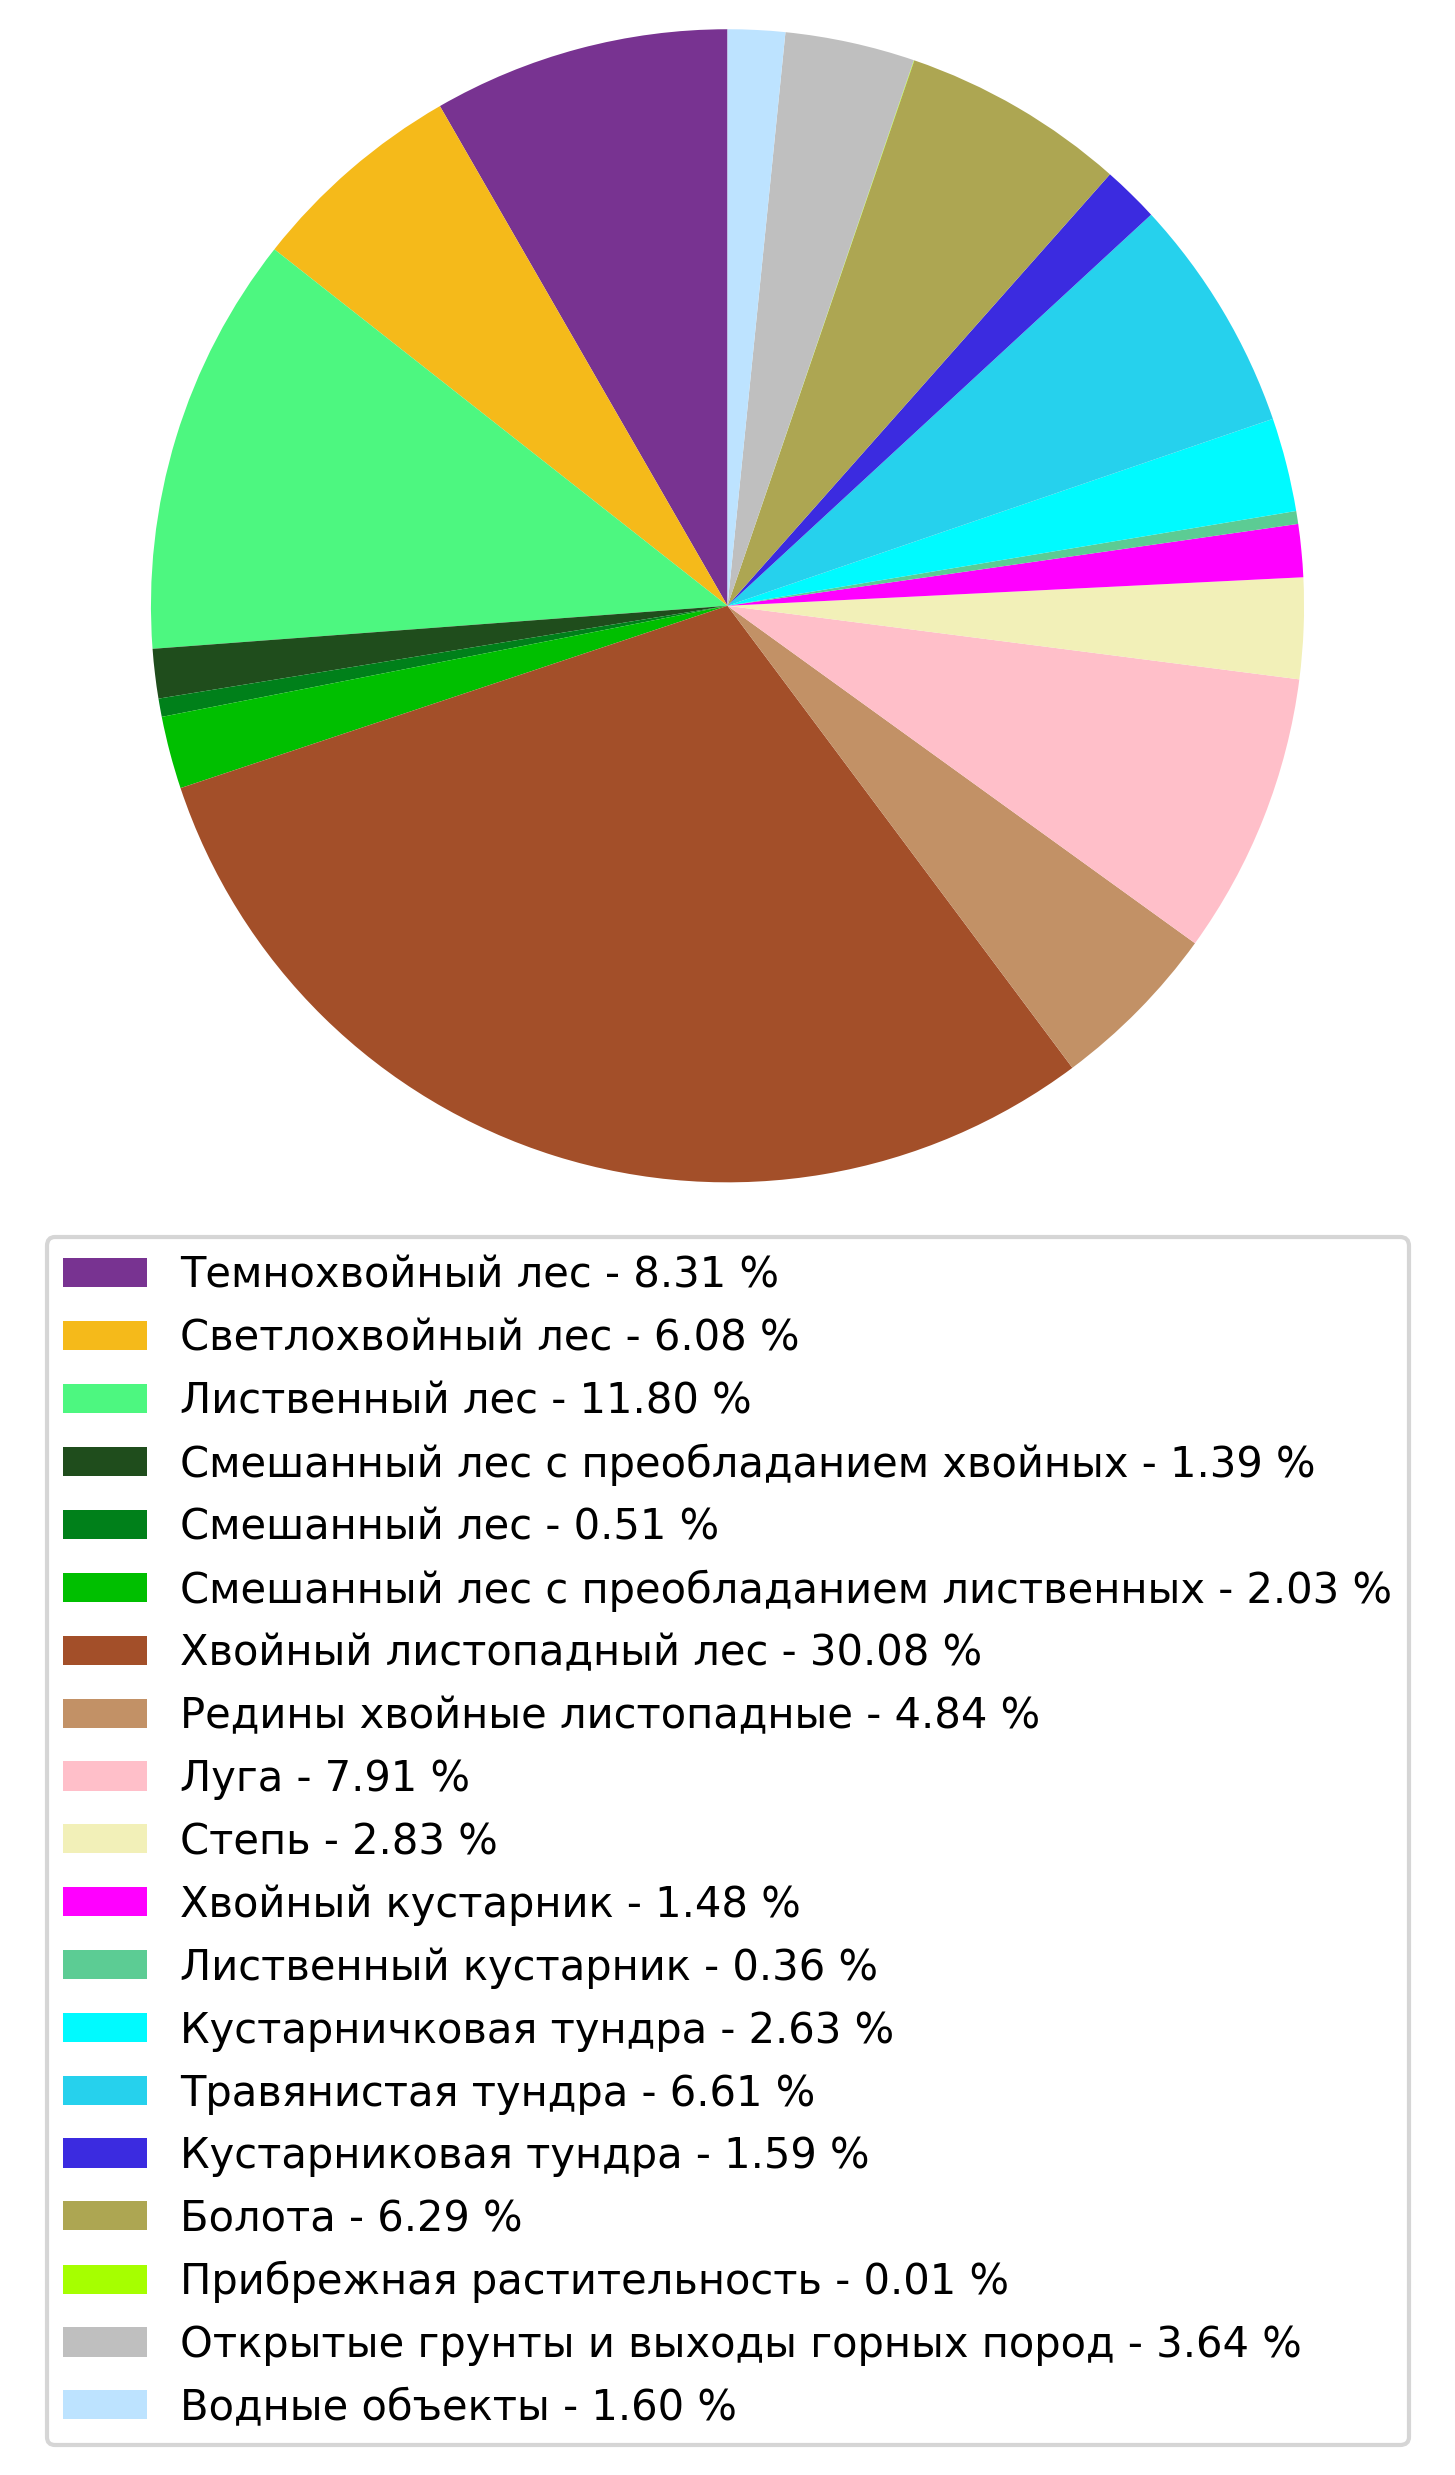

In [12]:
%%time

names = [class_name for class_name in classes_summary]
percents = [classes_summary[class_name]["percent"] for class_name in classes_summary]
colors = [classes_summary[class_name]["color"] for class_name in classes_summary]

labels = [f"{name} - {percent:1.2f} %" for name, percent in zip(names, percents)]

fig = plt.figure(figsize=(6, 10), dpi=300)
ax = fig.add_subplot(211)
ax.axis("equal")
pie = ax.pie(percents, colors=colors, startangle=90, radius=1.4)
legend_ax = fig.add_subplot(212)
legend_ax.axis("off")
legend_ax.legend(pie[0], labels, loc="center")

plt.savefig("text/images/classes-ratio.png", bbox_inches="tight", pad_inches=0)

#### Визуализация типов земного покрова

In [ ]:
%%time

for class_name in classes_summary:
    for class_id in classes_summary[class_name]["id"][1:]:
        data_vaex[data_vaex["CLASS"] == class_id]["CLASS"] = classes_summary[class_name]["id"][0]

In [6]:
df = vaex.example()
df  # Since this is the last statement in a cell, it will print the DataFrame in a nice HTML format.

wget failed, using urlretrieve


#,id,x,y,z,vx,vy,vz,E,L,Lz,FeH
0,0,1.2318684,-0.39692867,-0.59805775,301.15527,174.05948,27.427546,-149431.4,407.38898,333.95554,-1.0053853
1,23,-0.16370061,3.6542213,-0.25490645,-195.00023,170.47217,142.53023,-124247.95,890.24115,684.6676,-1.708667
2,32,-2.120256,3.3260527,1.7078403,-48.63423,171.6473,-2.0794373,-138500.55,372.2411,-202.17618,-1.8336141
3,8,4.715589,4.585251,2.2515438,-232.42084,-294.85083,62.85865,-60037.04,1297.6304,-324.6875,-1.4786882
4,16,7.217187,11.994717,-1.0645622,-1.6891745,181.32935,-11.333611,-83206.84,1332.799,1328.949,-1.8570484
...,...,...,...,...,...,...,...,...,...,...,...
"329,995",21,1.9938701,0.7892761,0.2220599,-216.9299,16.12442,-211.24438,-146457.44,457.72247,203.36758,-1.7451677
"329,996",25,3.7180912,0.7213376,1.6415337,-185.9216,-117.250824,-105.49866,-126627.11,335.00256,-301.837,-0.9822322
"329,997",14,0.36885077,13.029609,-3.6339347,-53.677147,-145.15771,76.7091,-84912.26,817.1376,645.8507,-1.7645613
"329,998",18,-0.112592645,1.4529126,2.1689527,179.30865,205.7971,-68.75873,-133498.47,724.00024,-283.69104,-1.8808953


In [27]:
%%time

coordinates_column_names = data_vaex.column_names[1:3]
brightness_column_names = data_vaex.column_names[3:]

class_id = 15
data_vaex[data_vaex["CLASS"] == class_id][brightness_column_names]

CPU times: total: 78.1 ms
Wall time: 82.8 ms


#,WINTER1,WINTER2,SPRING1,SPRING2,SPRING3,SUMMER1,SUMMER2,SUMMER3,FALL1,FALL2,FALL3
0,2726,3173,376,1546,1539,269,2305,1456,282,1285,838
1,2556,2835,371,1520,1534,253,2107,1419,230,1237,871
2,2210,2561,358,1447,1481,255,1951,1307,281,1335,887
3,2408,2796,364,1469,1424,263,1909,1286,316,1502,1003
4,2260,2724,346,1466,1495,245,2051,1368,268,1229,982
...,...,...,...,...,...,...,...,...,...,...,...
"6,153,029",1273,2018,403,1623,1442,281,2033,1236,230,1670,1029
"6,153,030",1645,2406,528,1711,1455,264,2074,1235,266,1784,1051
"6,153,031",1533,2240,461,1558,1461,293,2012,1251,249,1718,1054
"6,153,032",655,1607,313,2033,1135,240,2446,1187,200,1870,1029


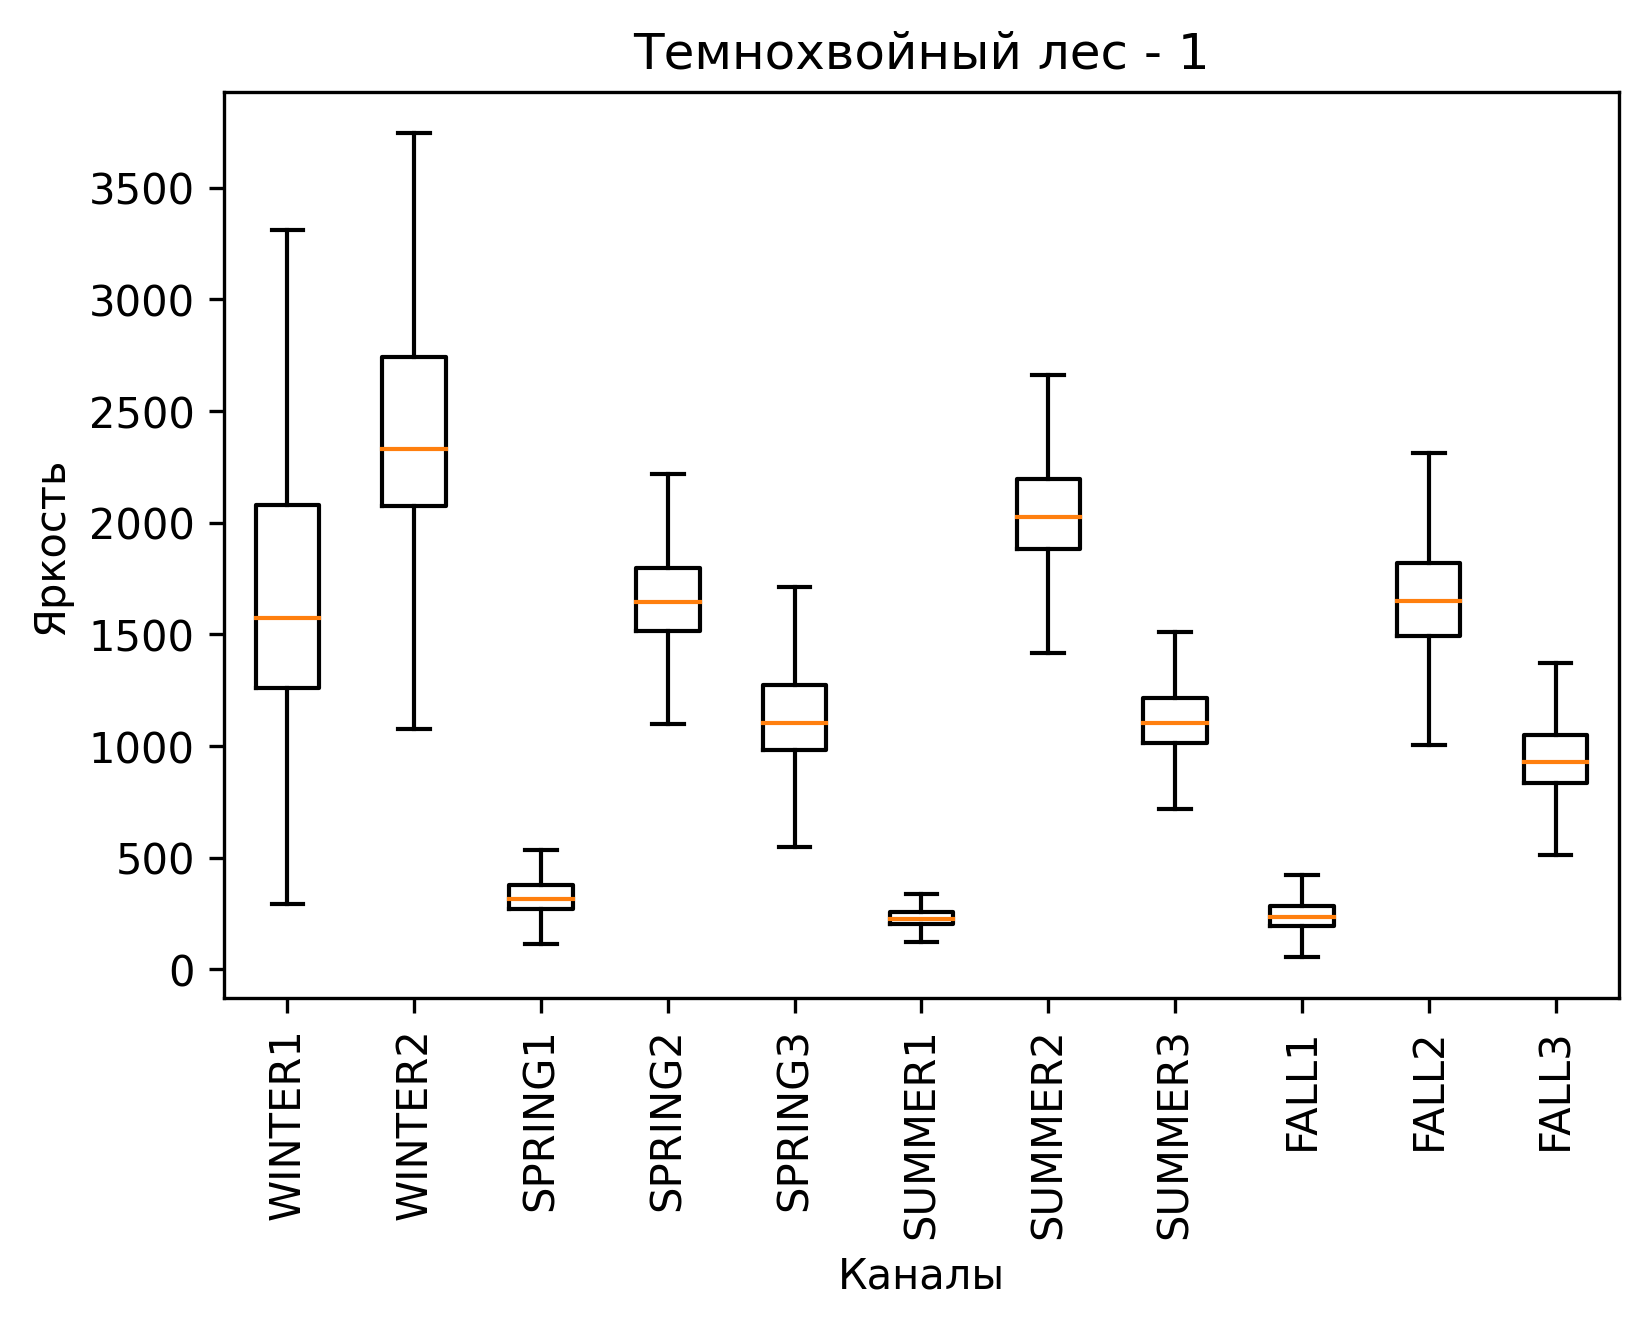

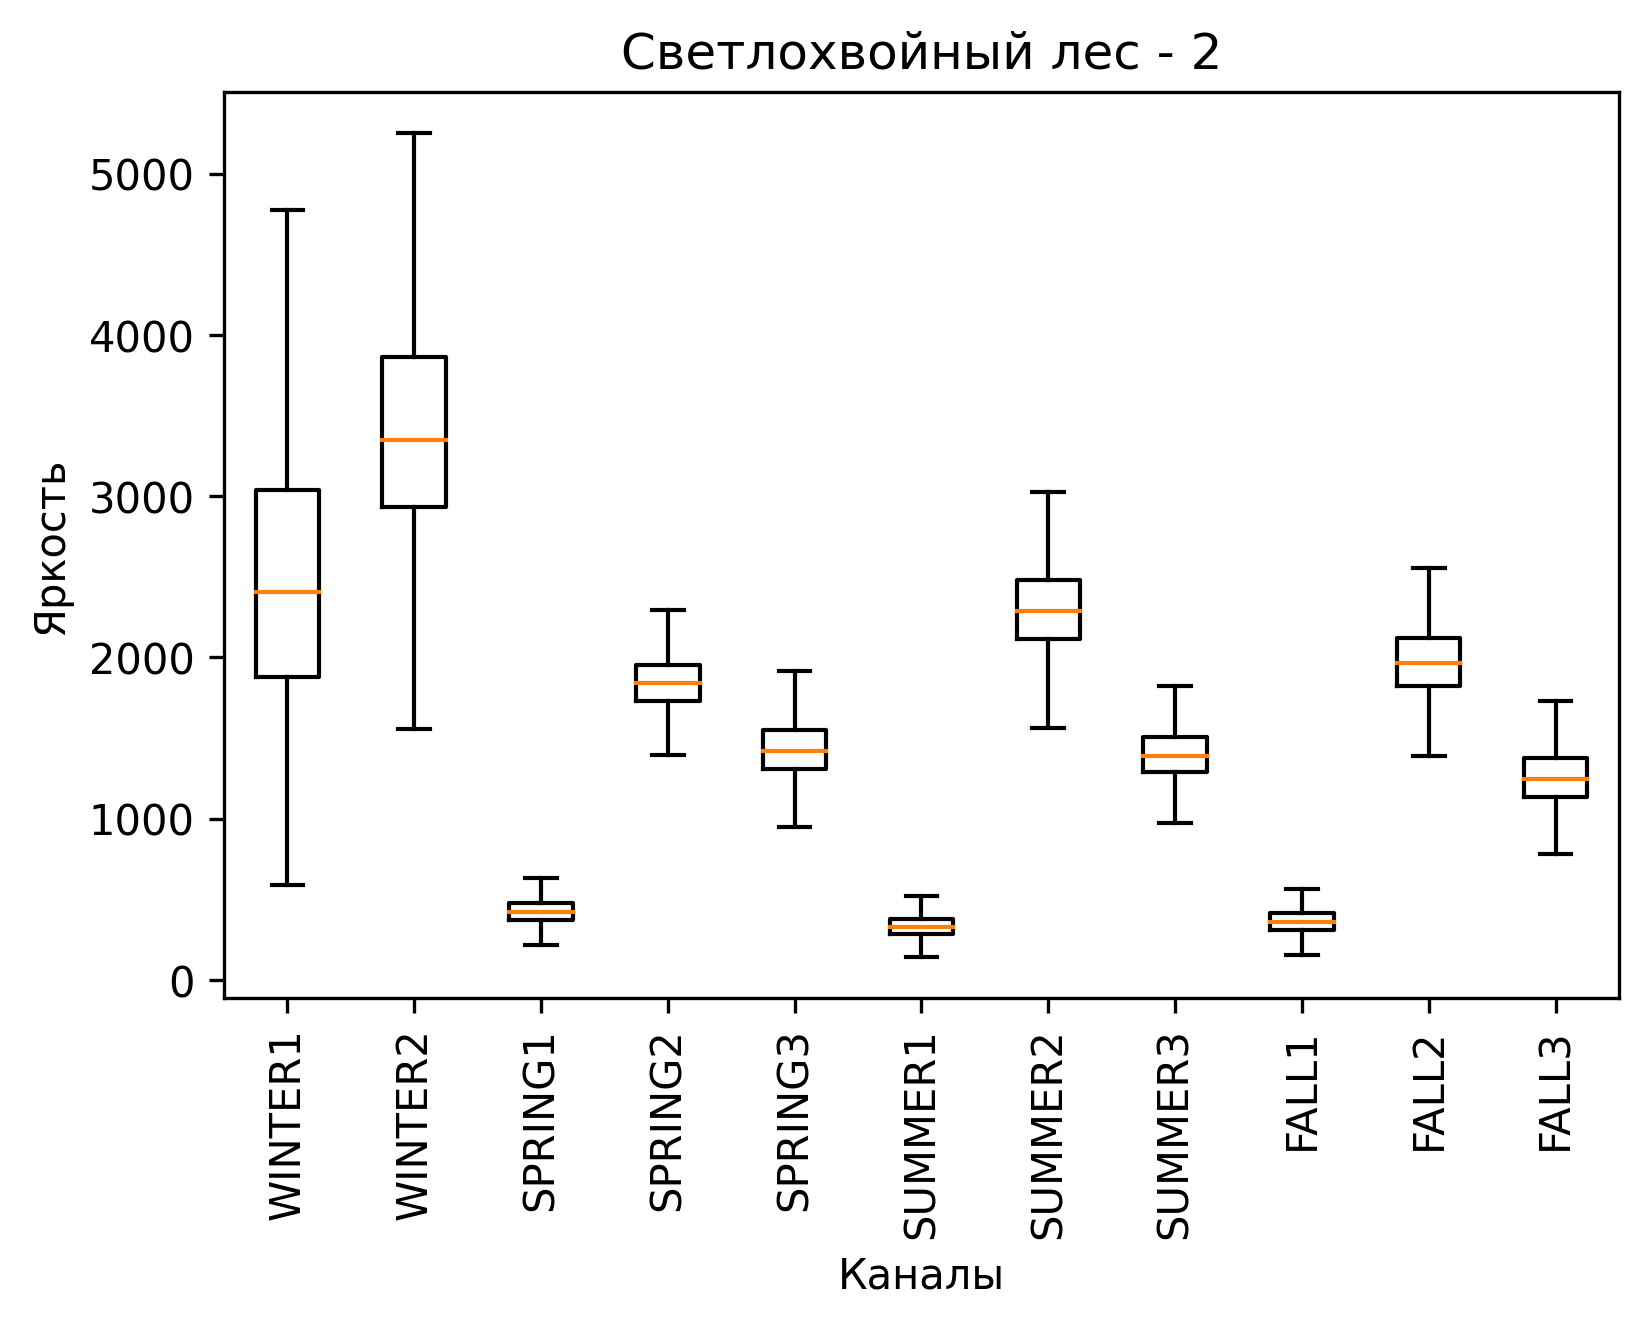

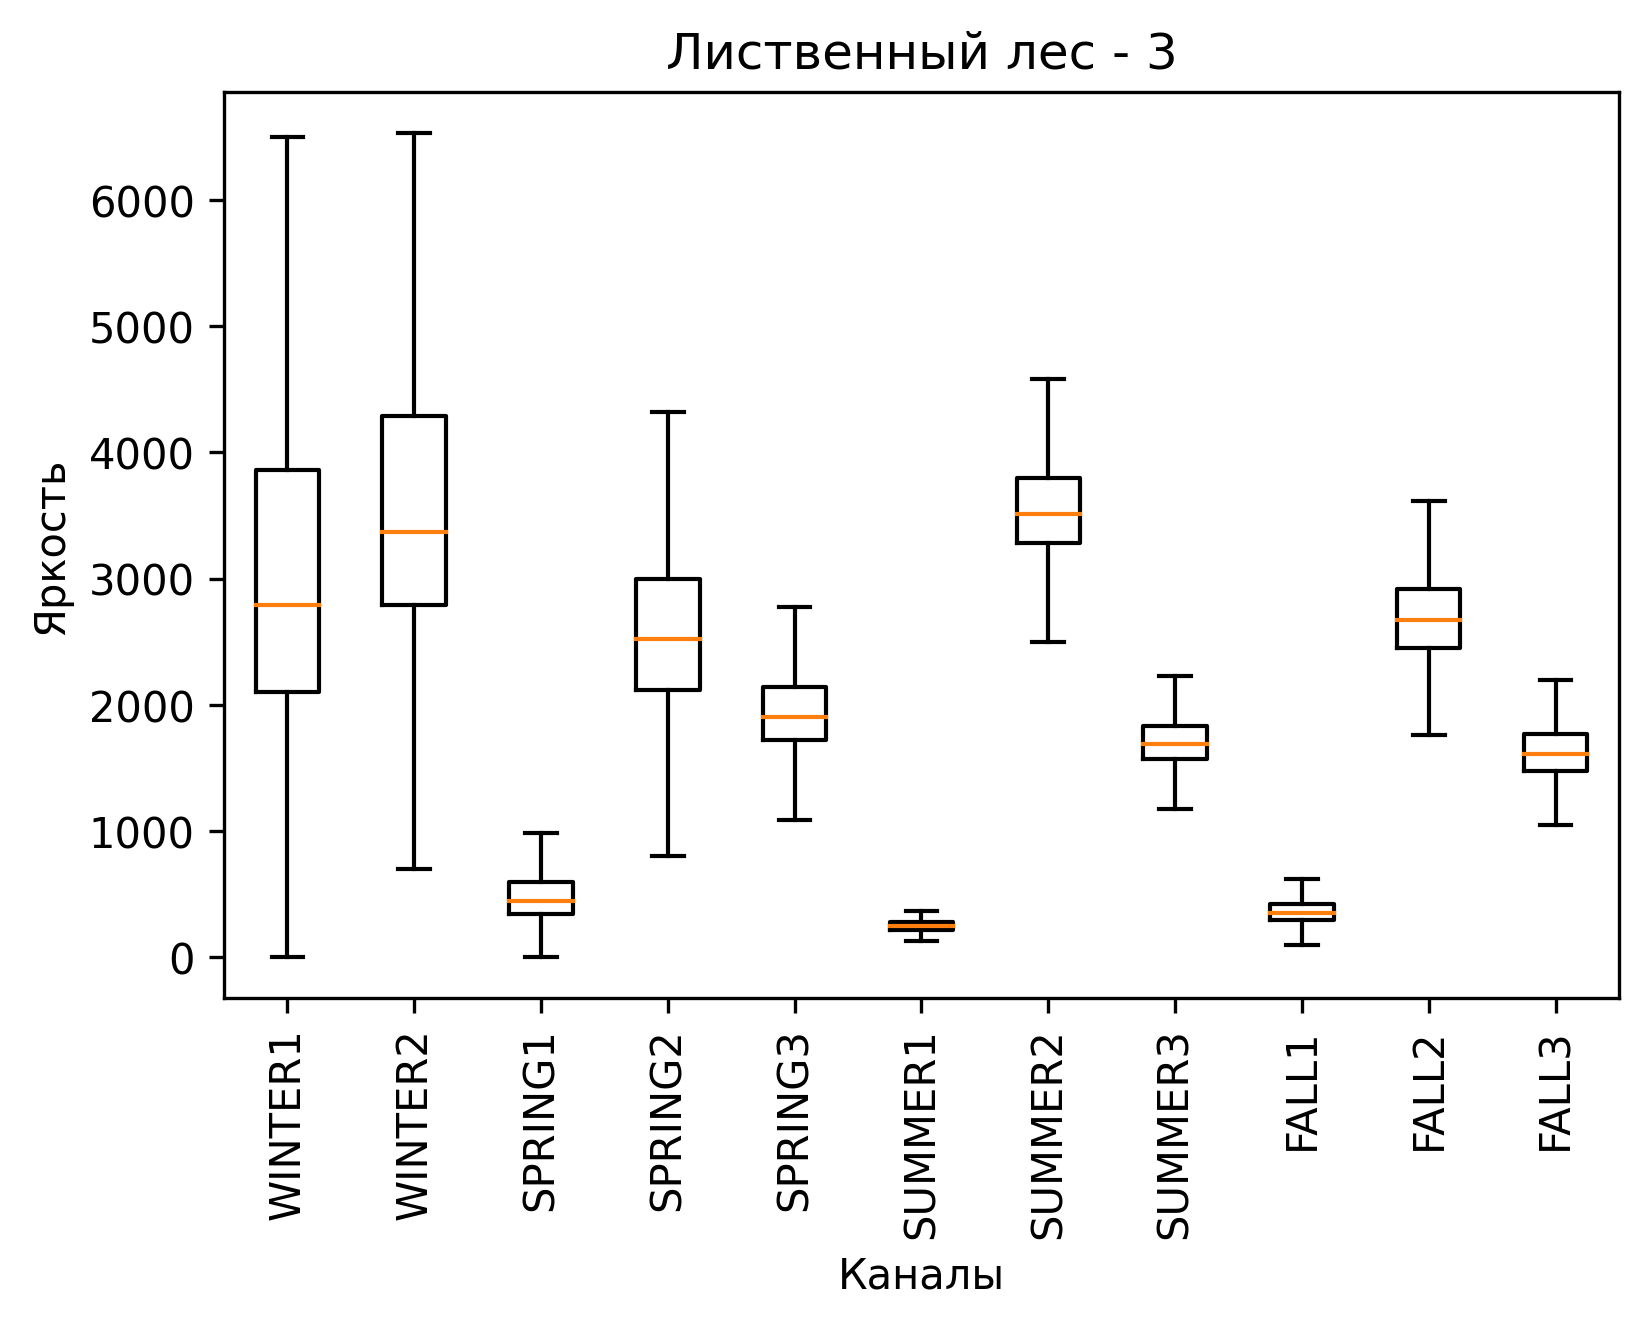

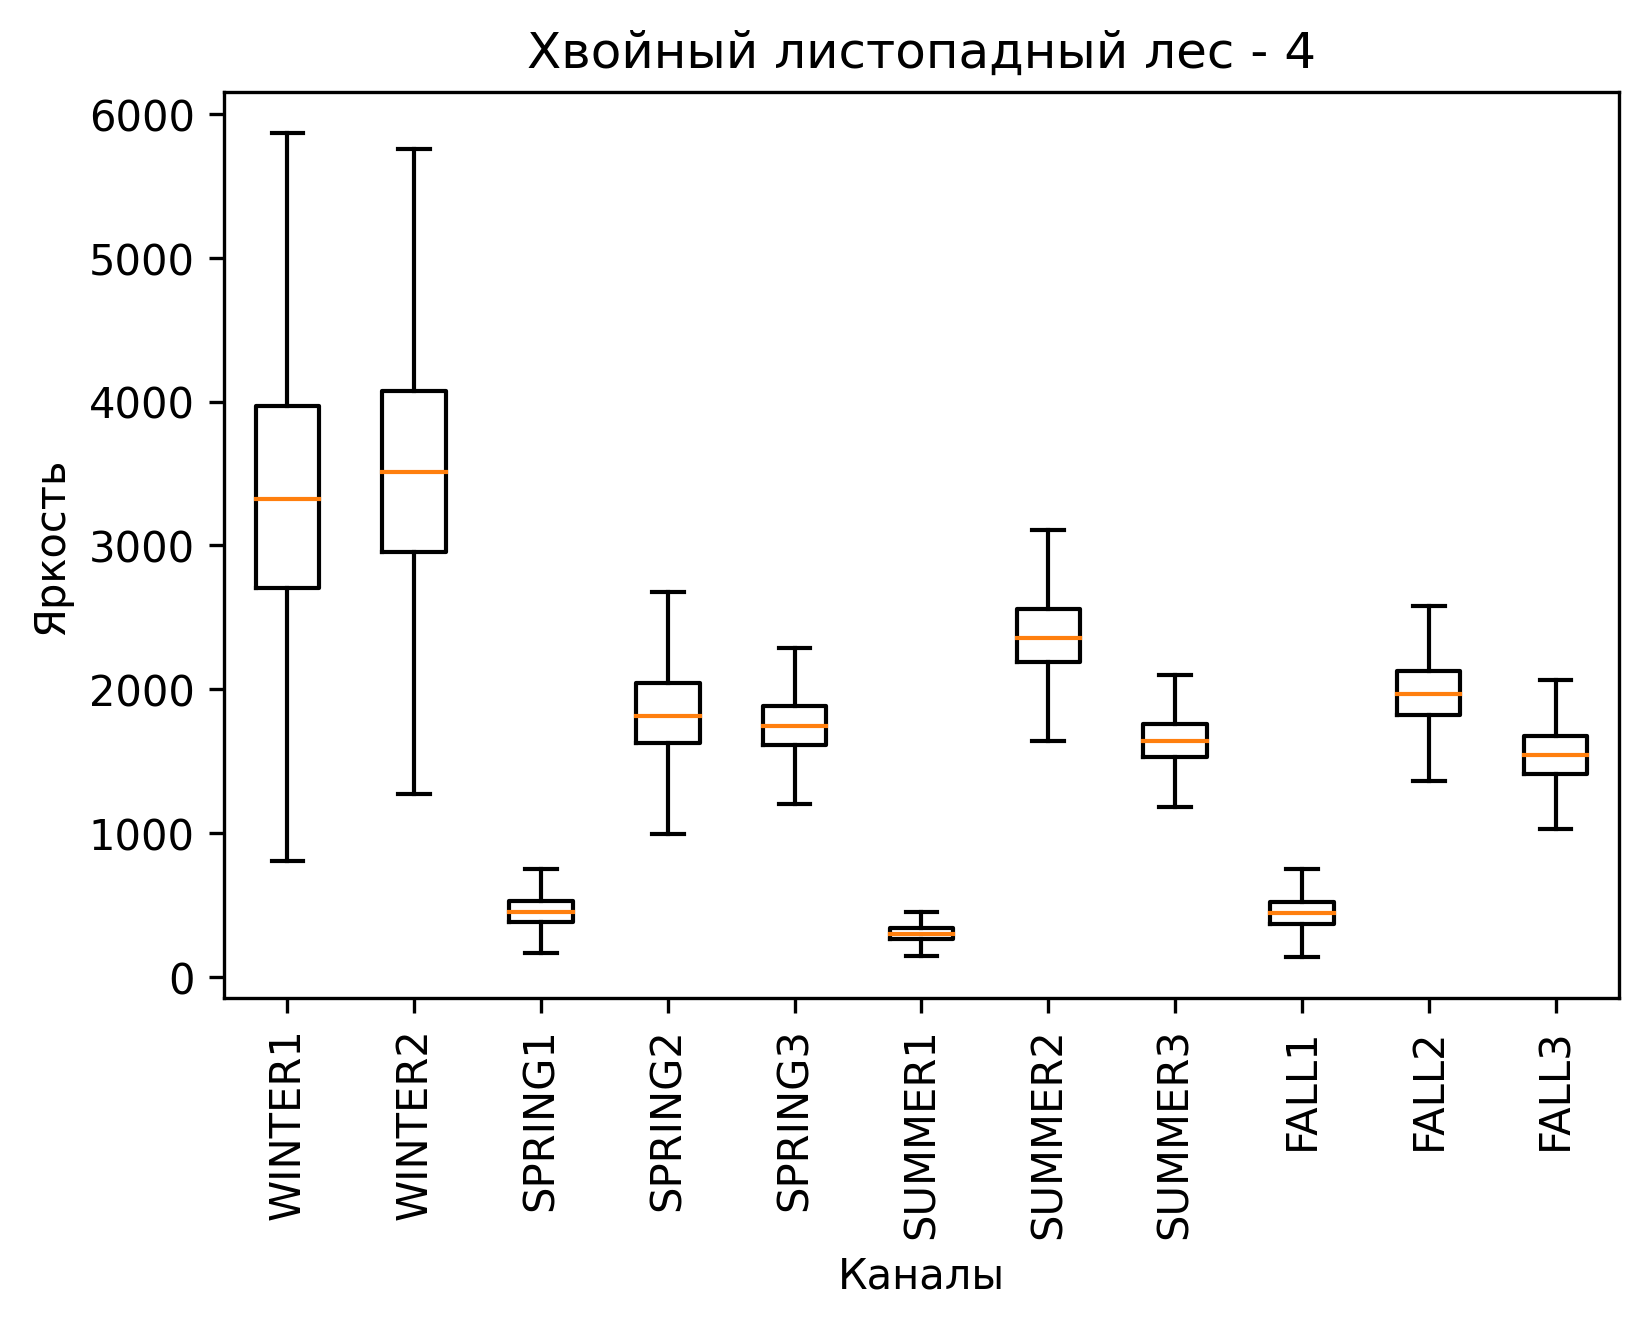

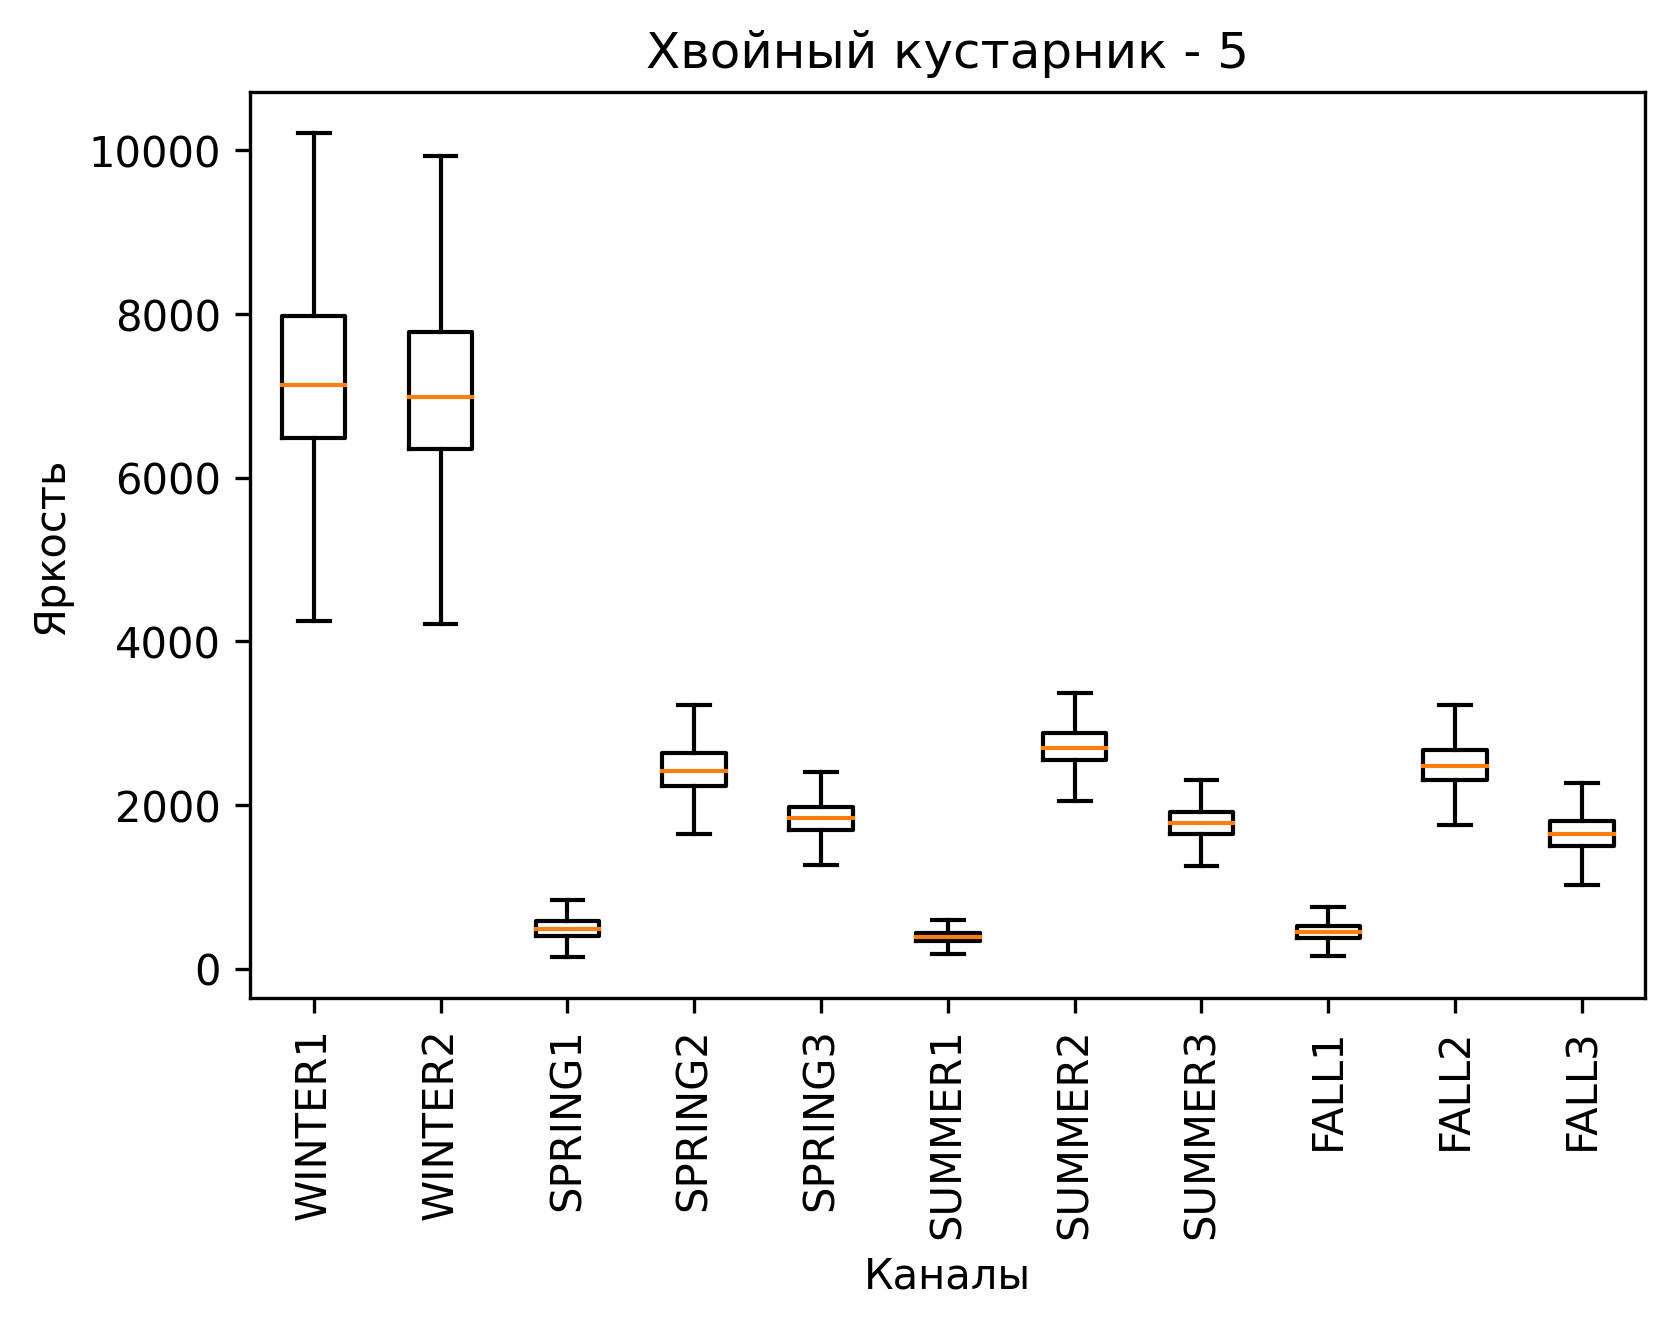

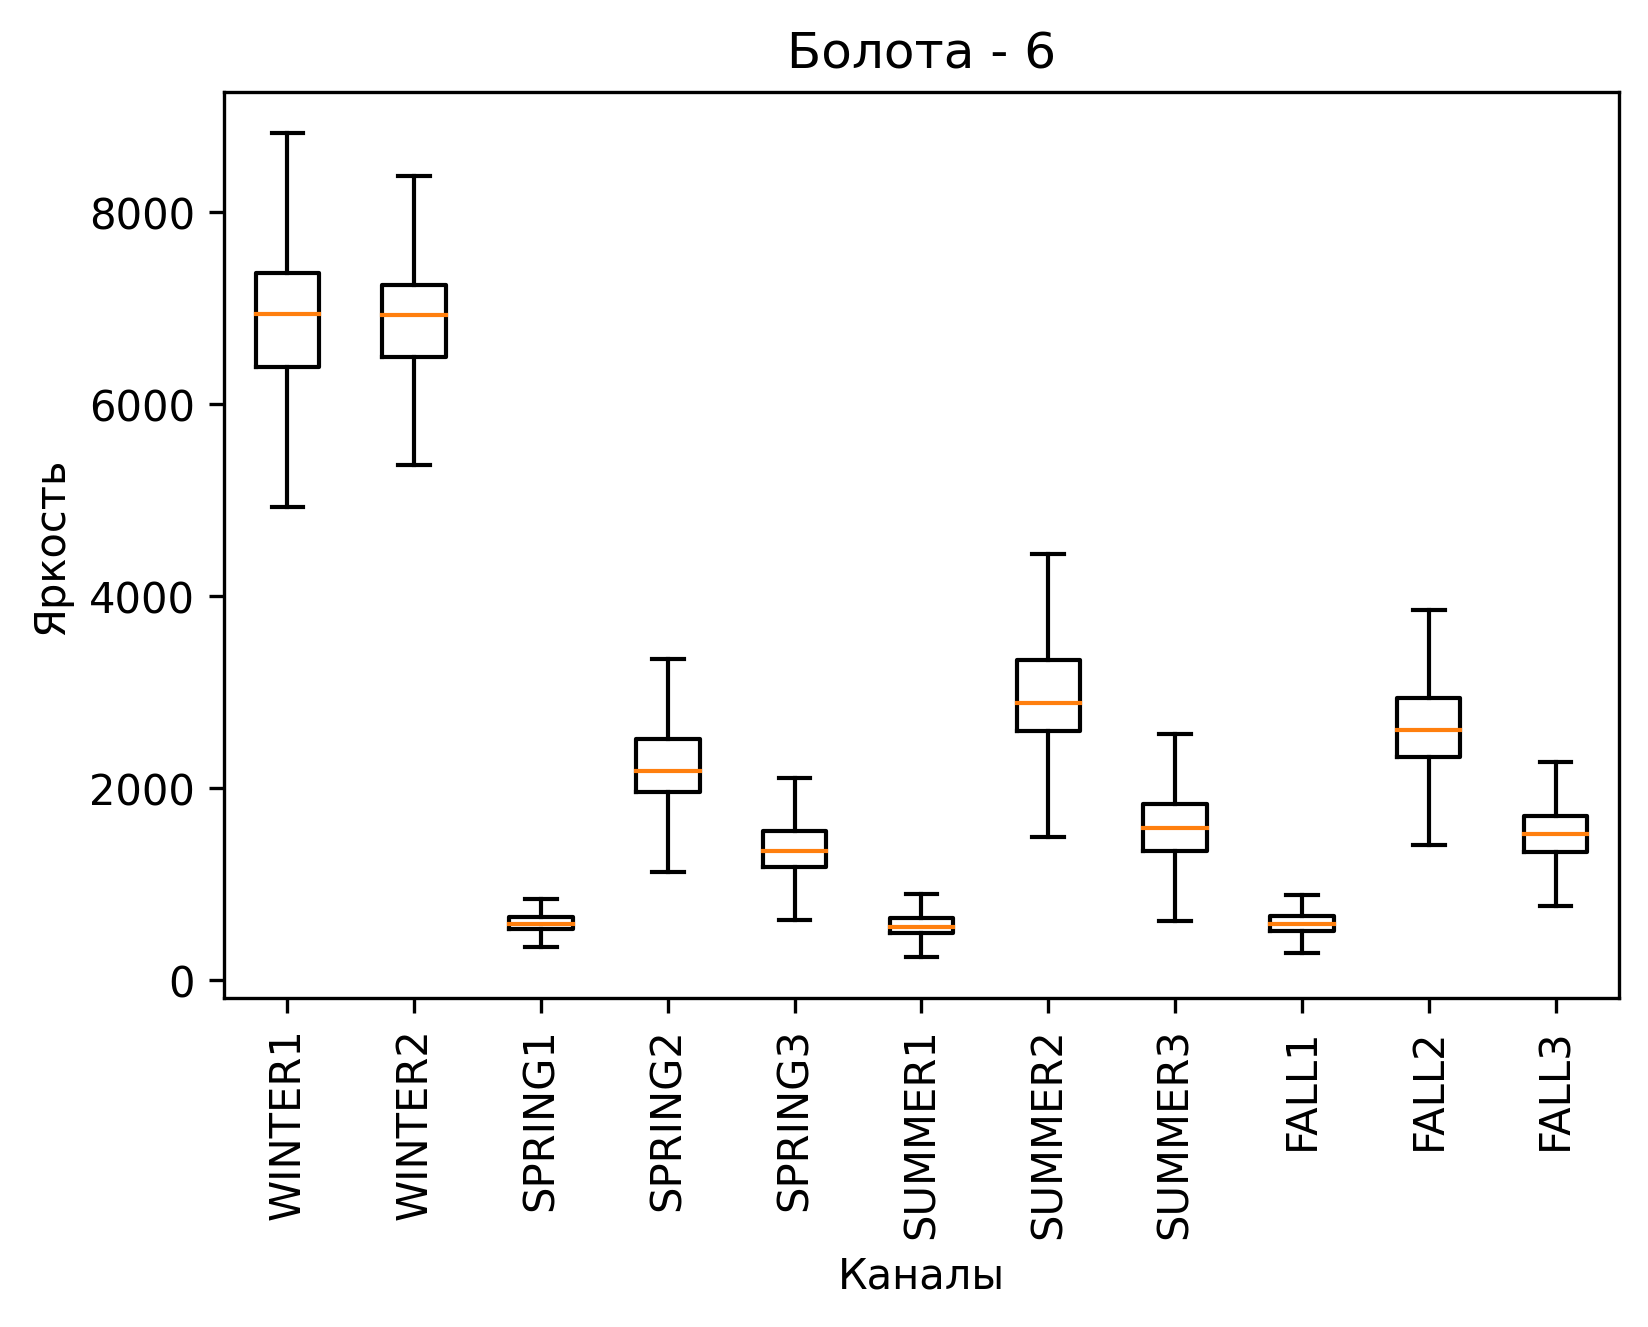

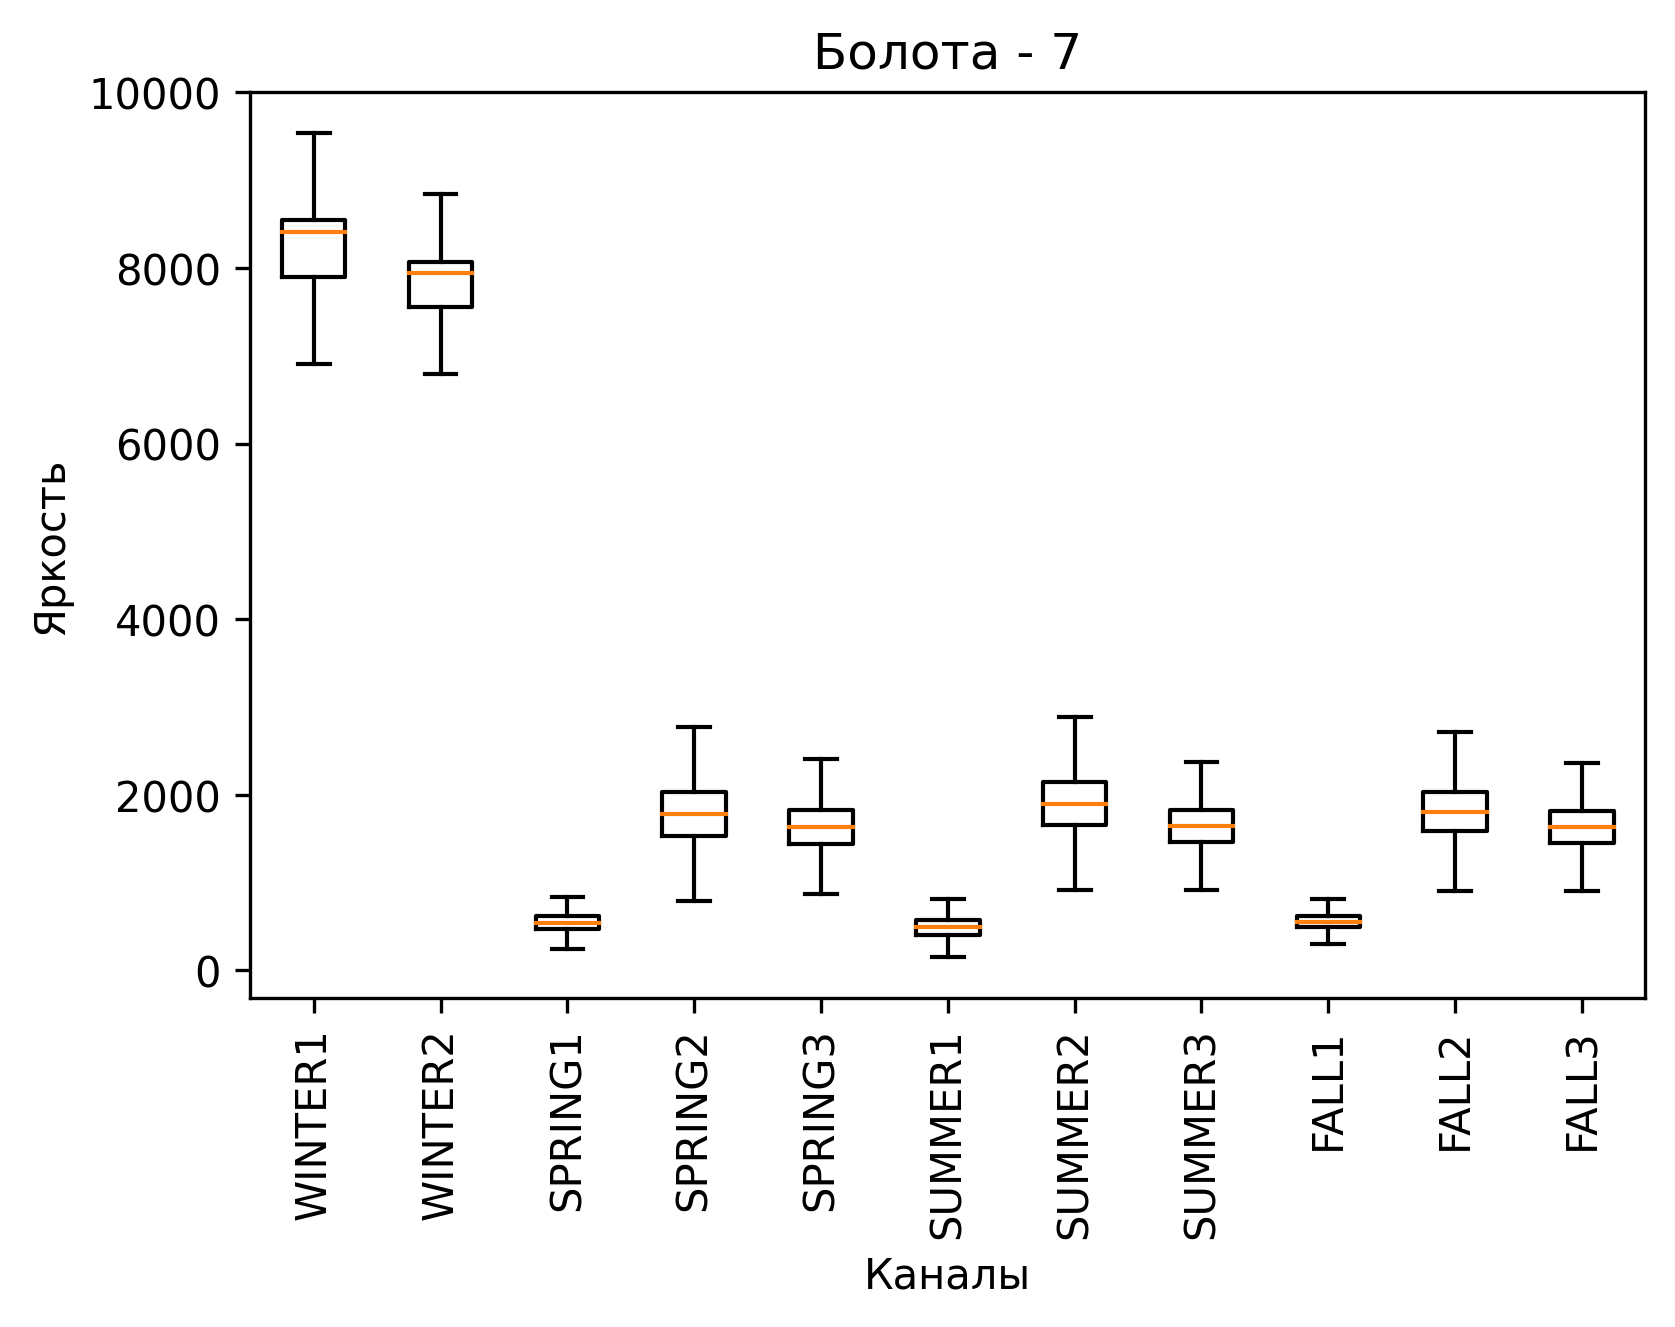

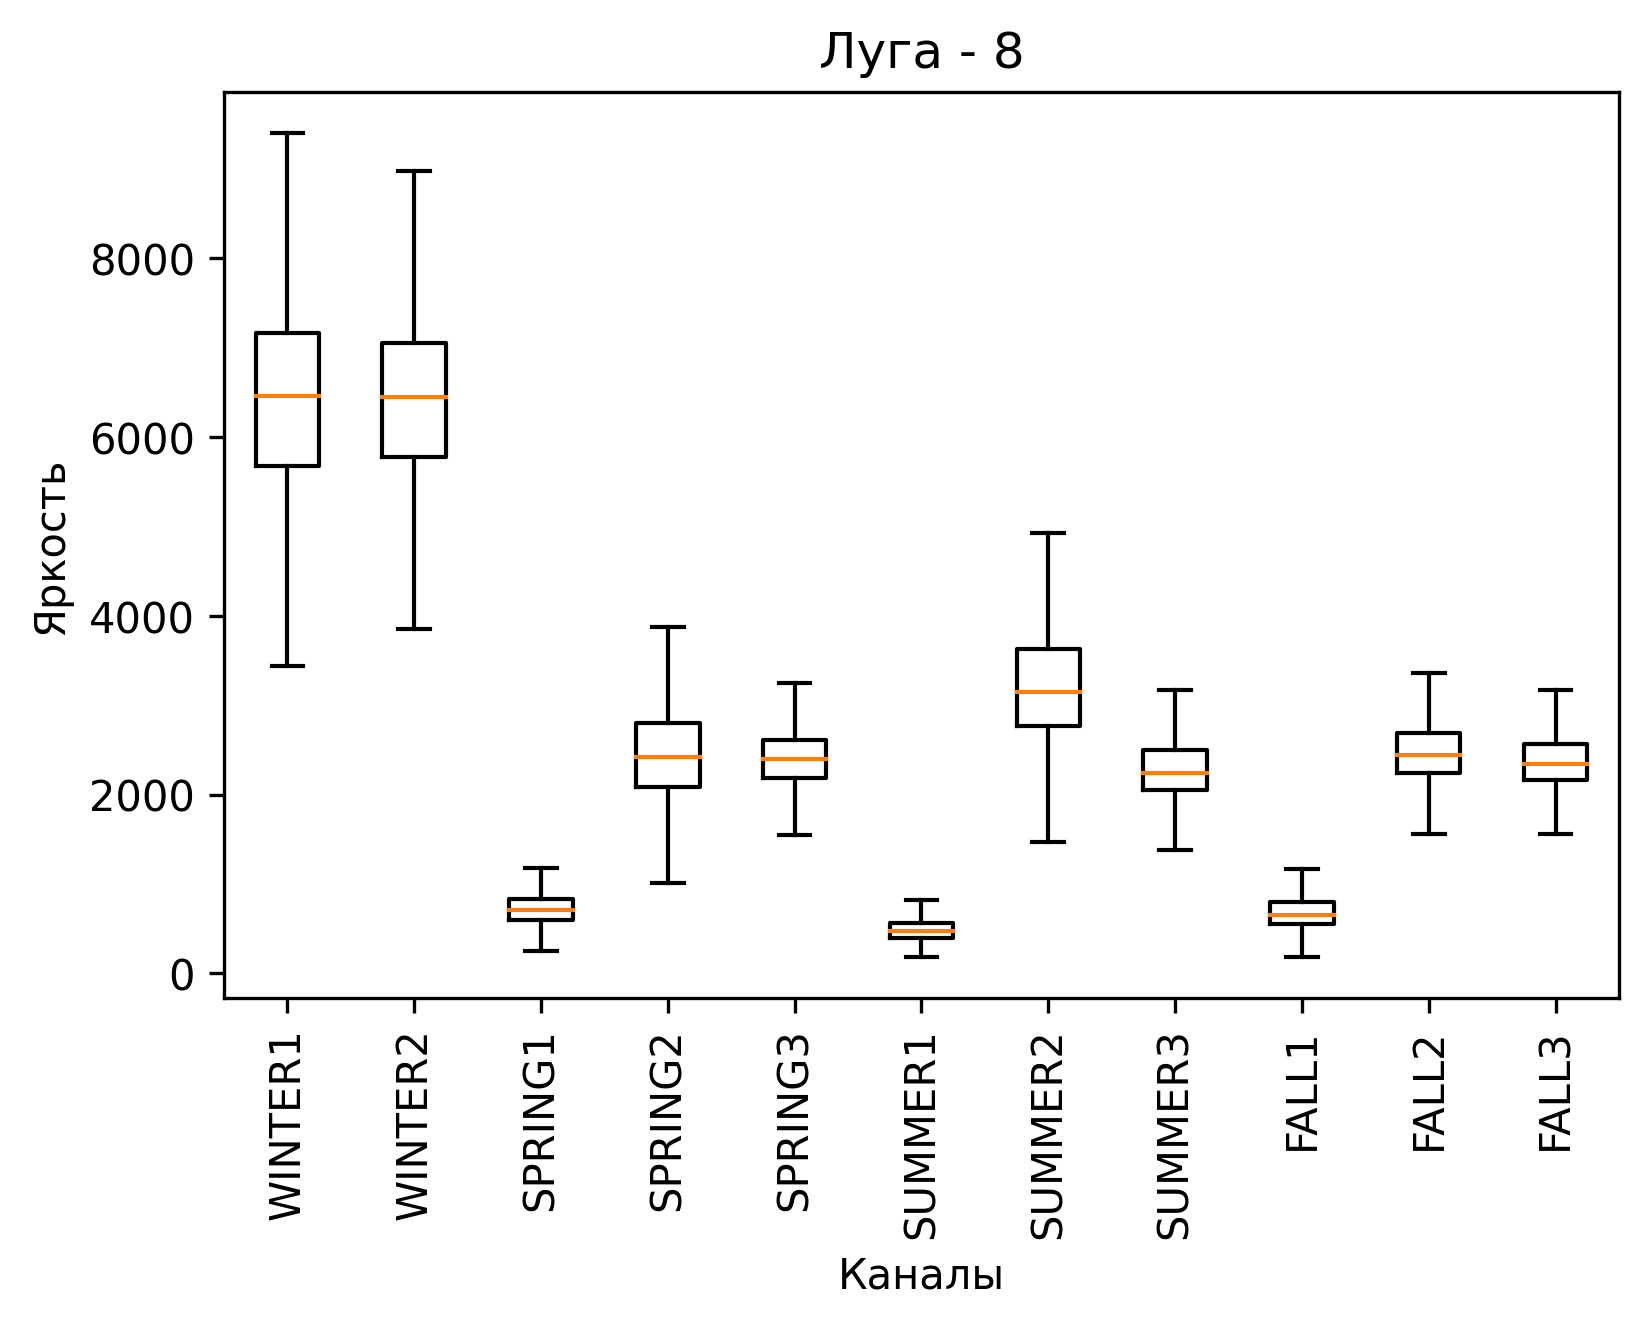

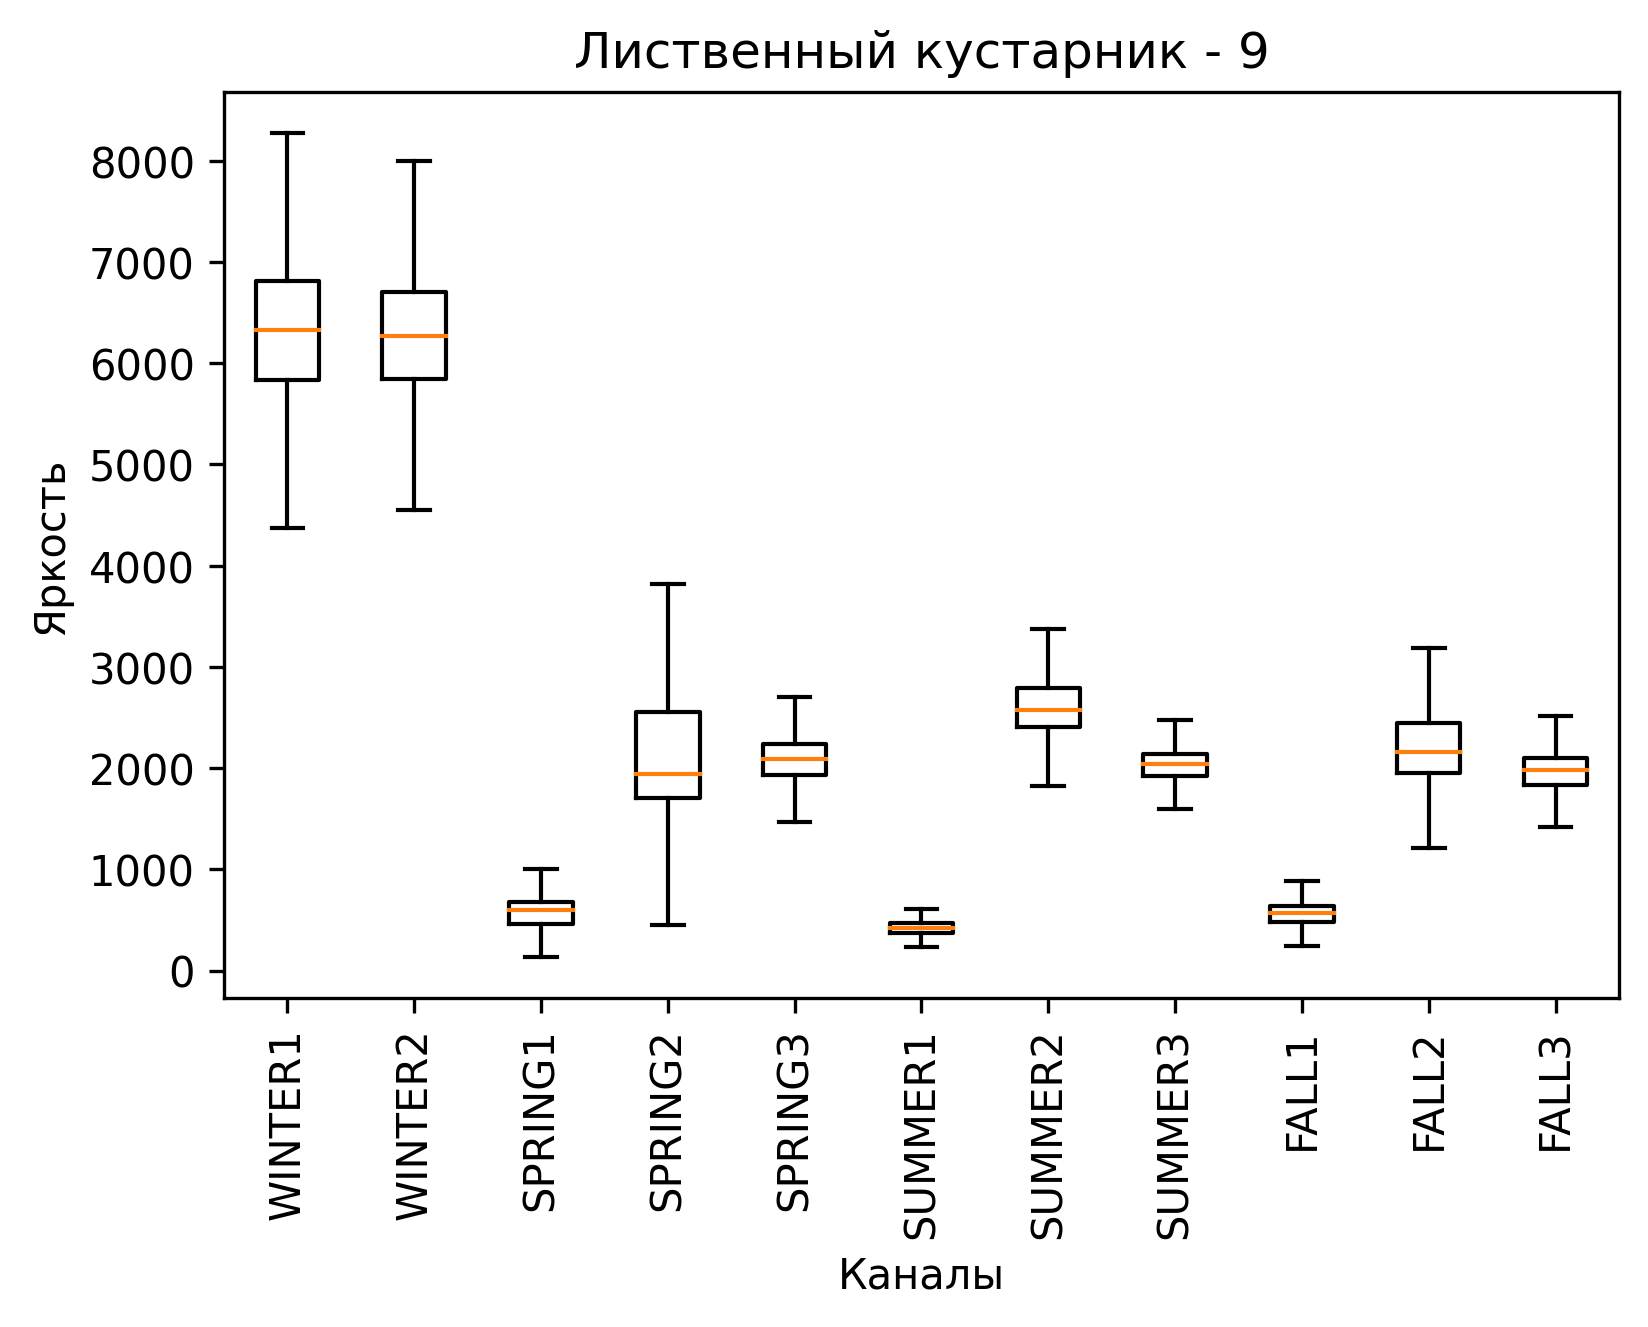

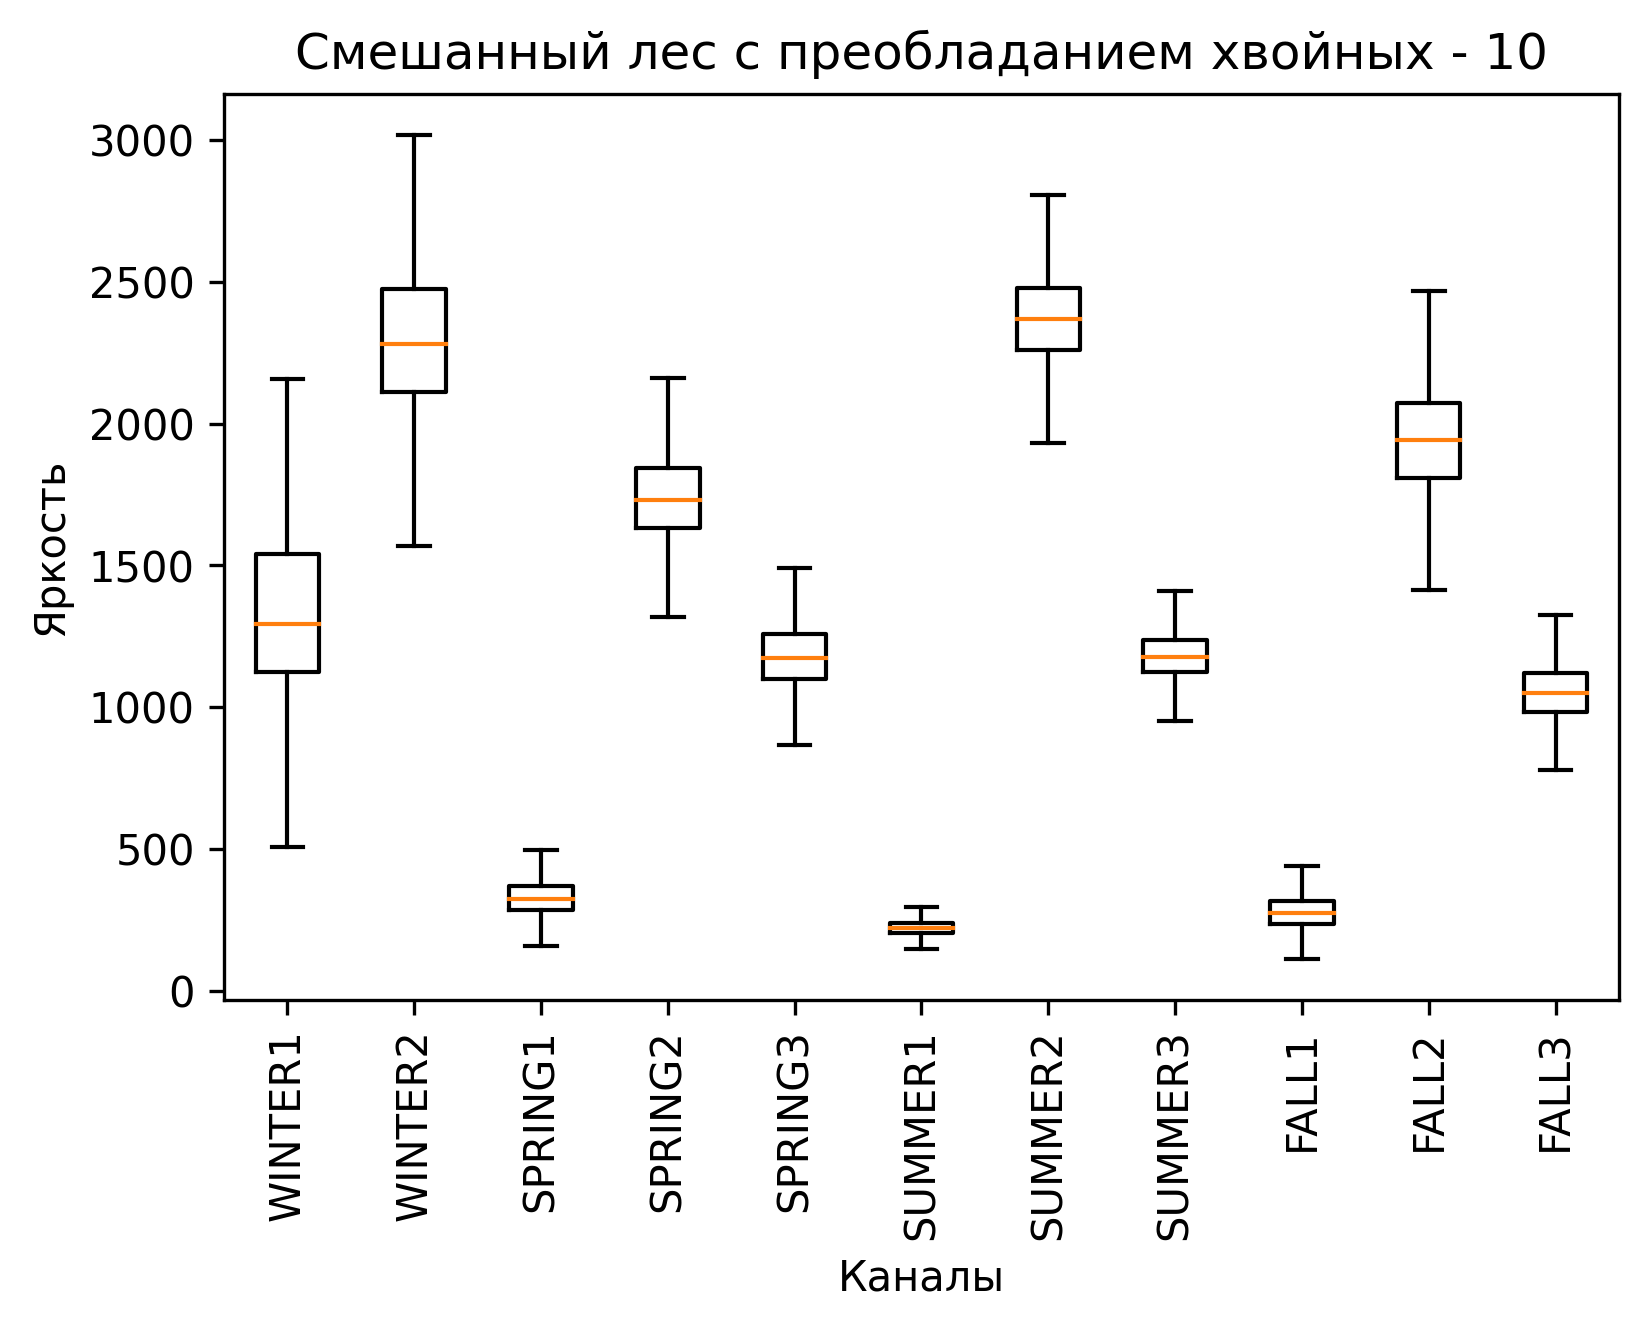

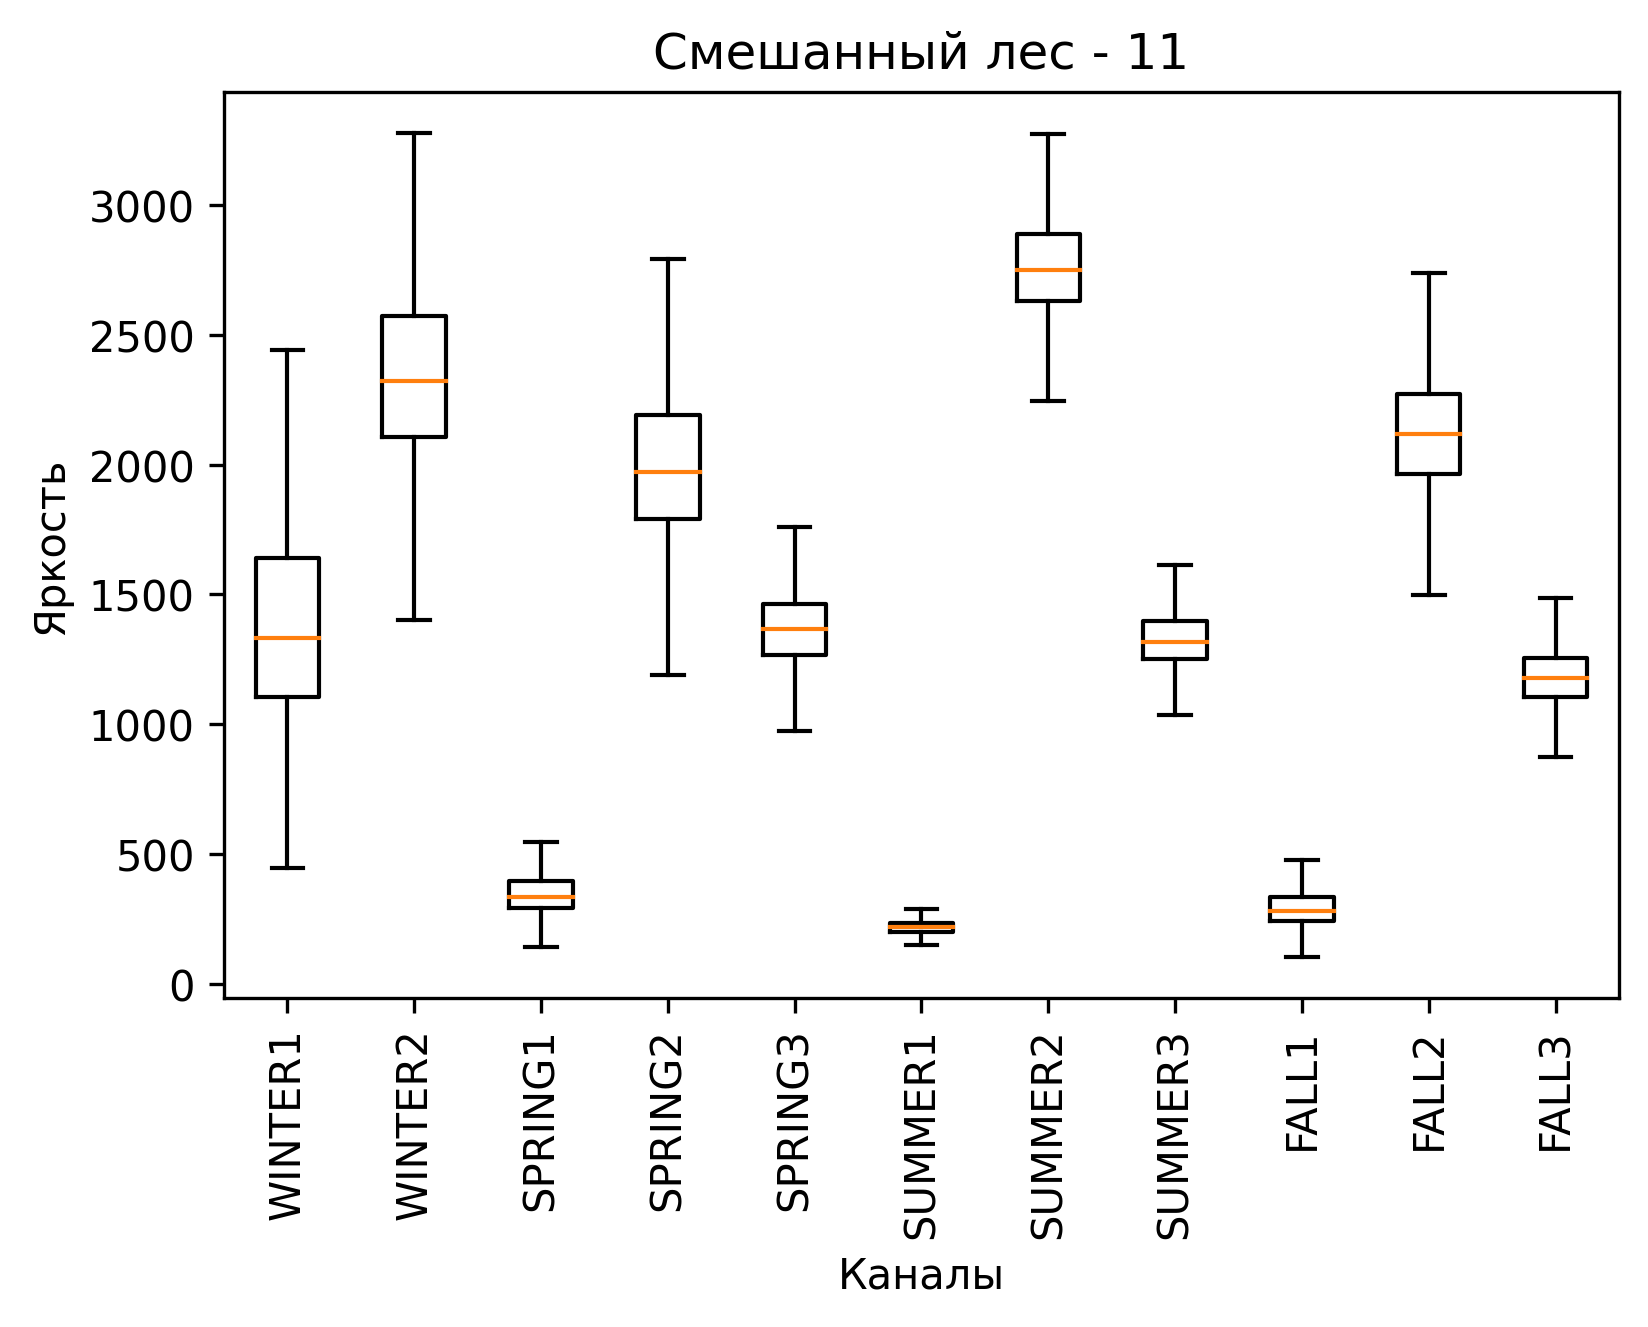

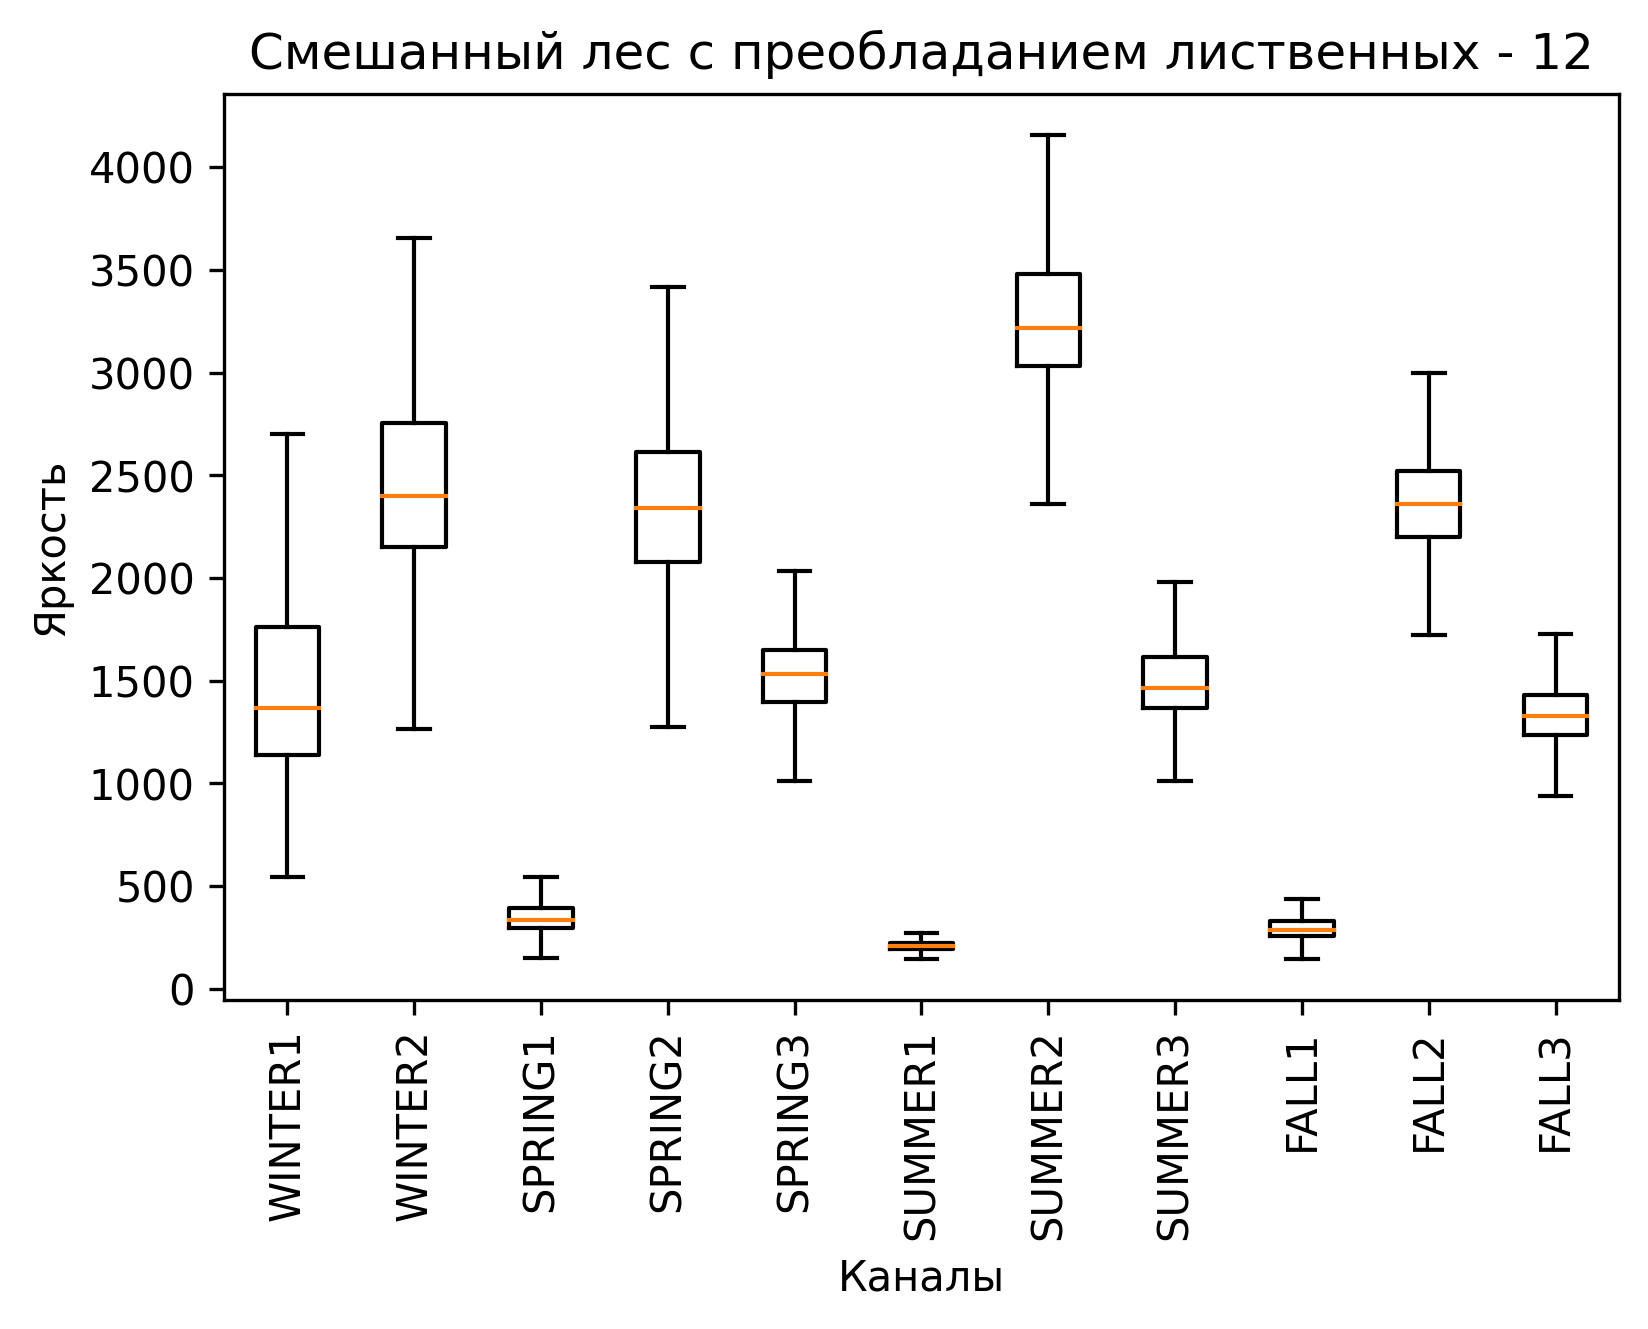

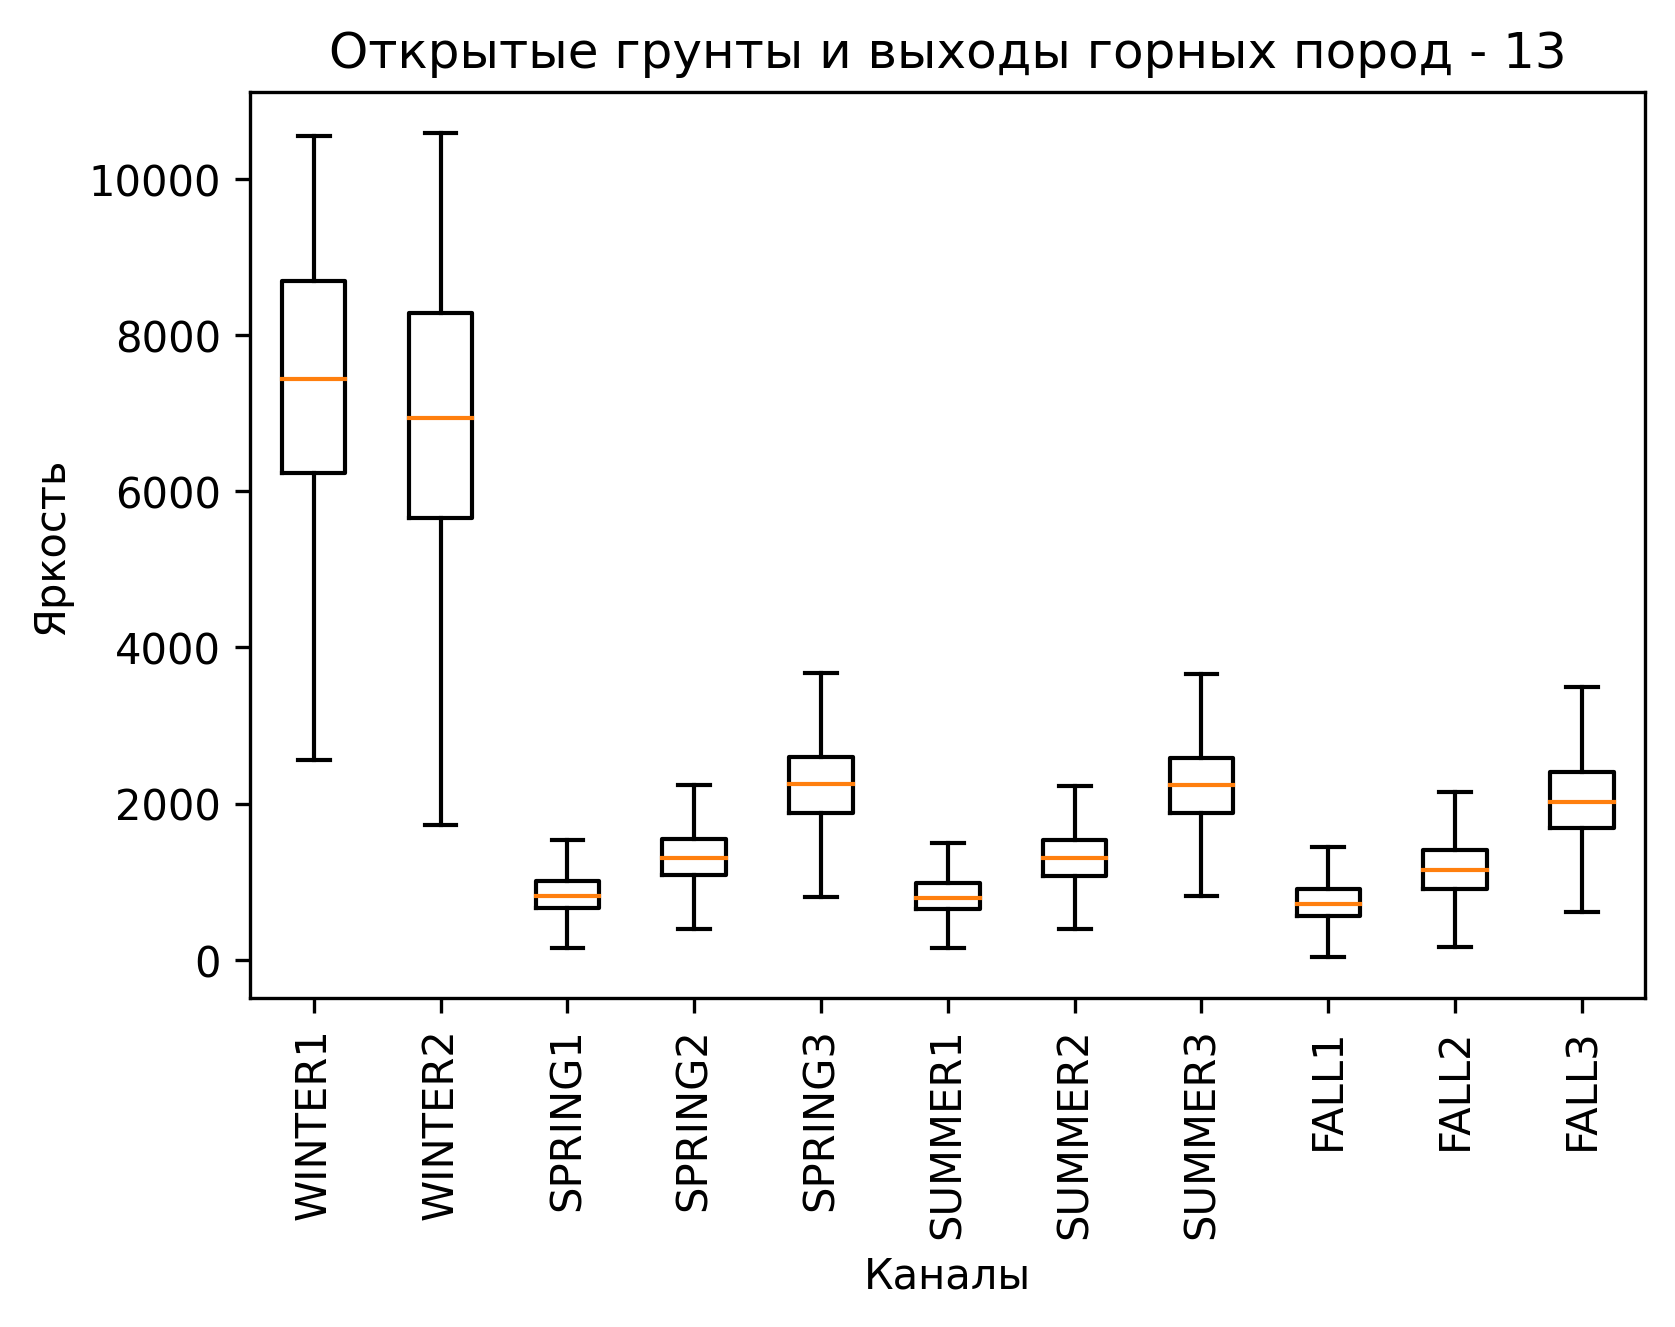

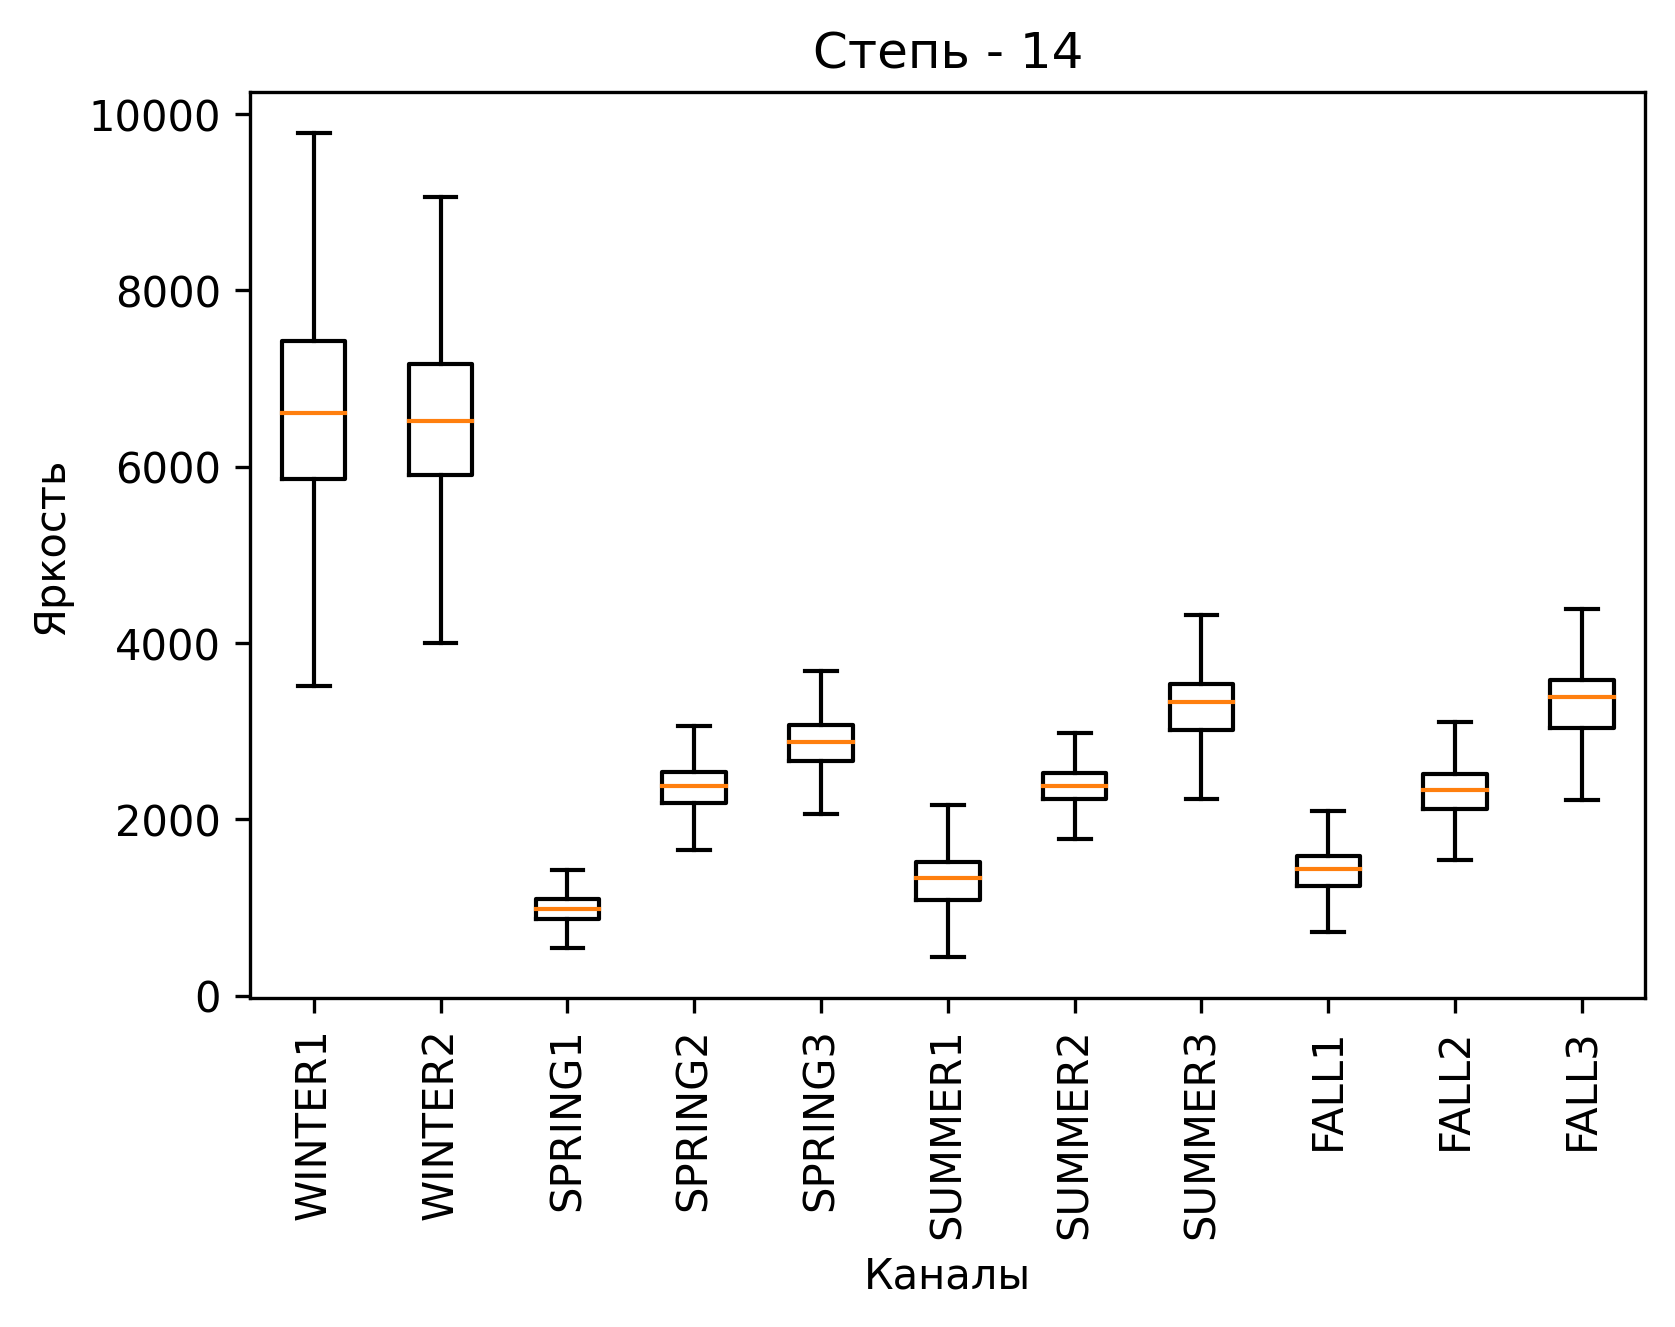

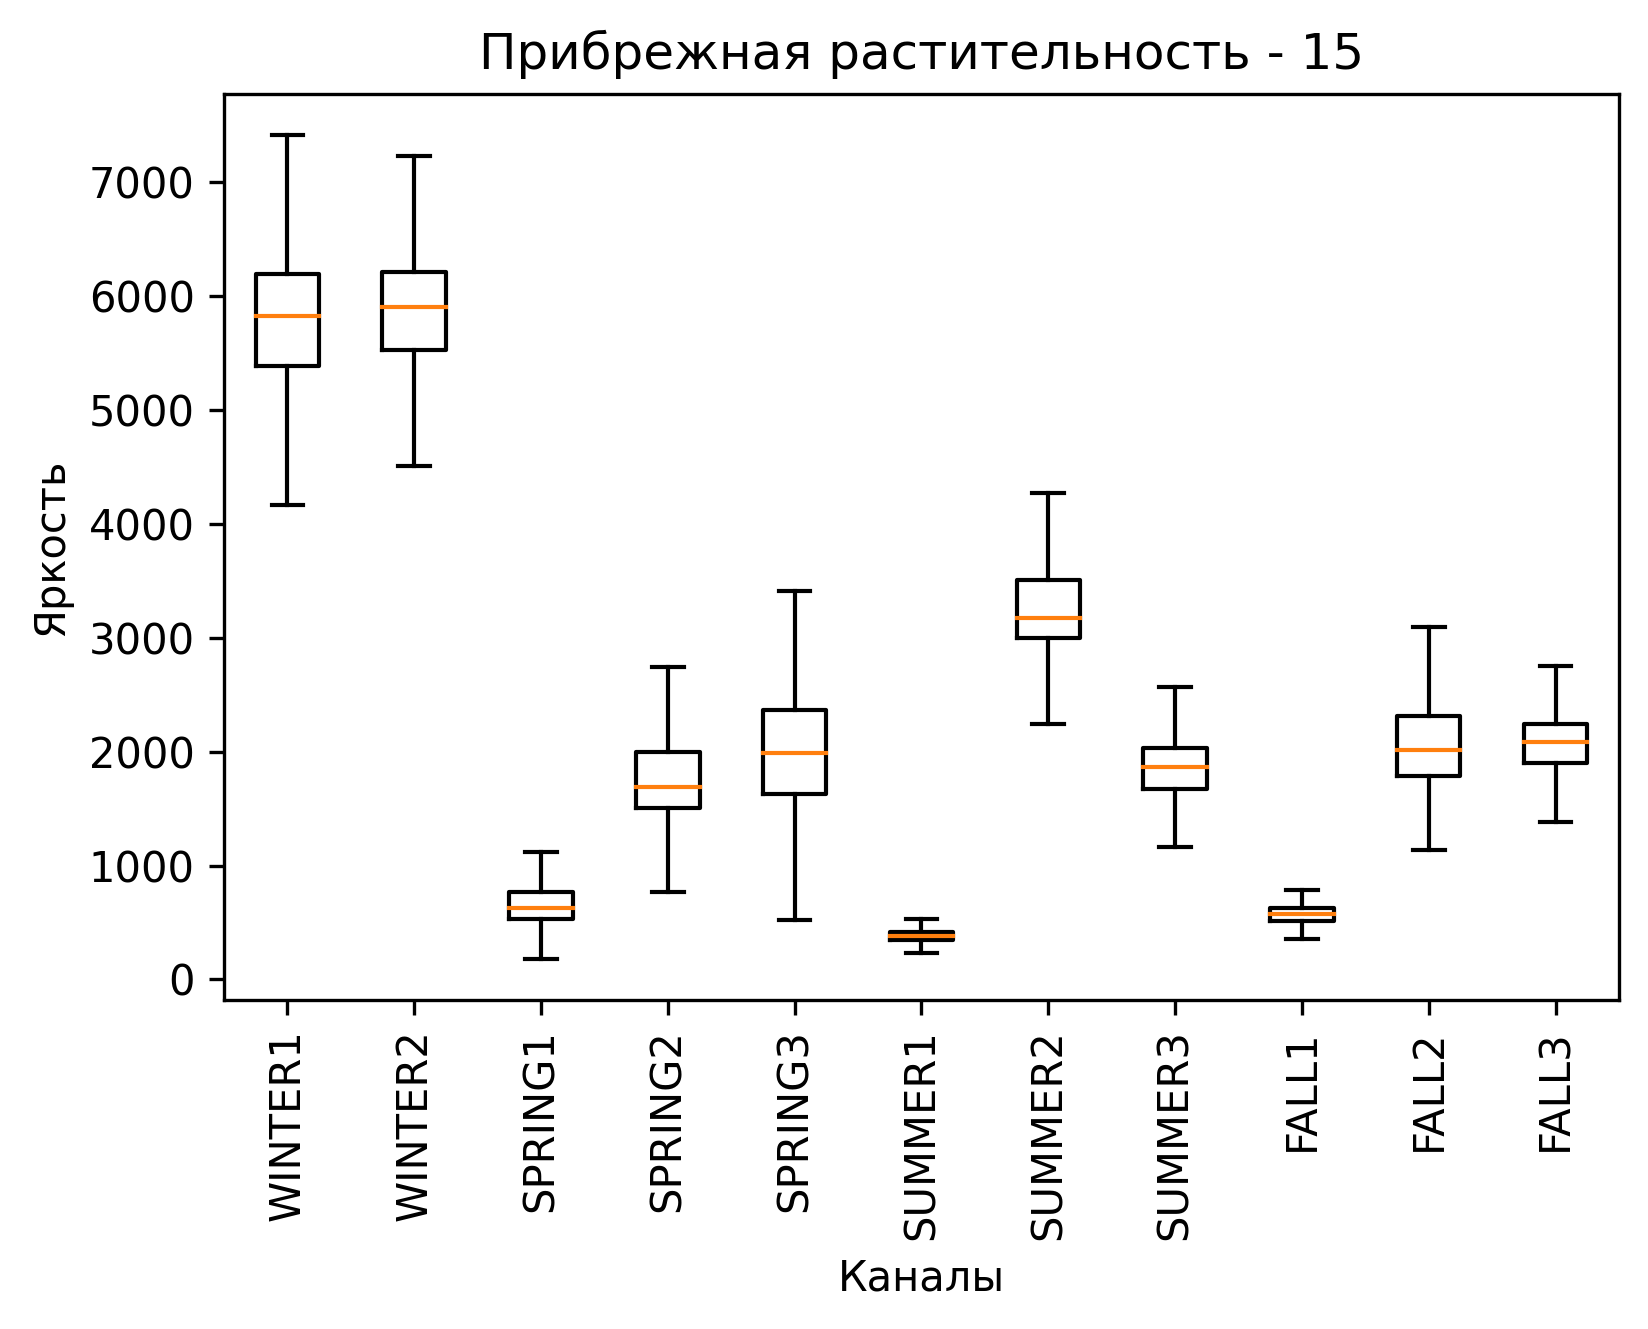

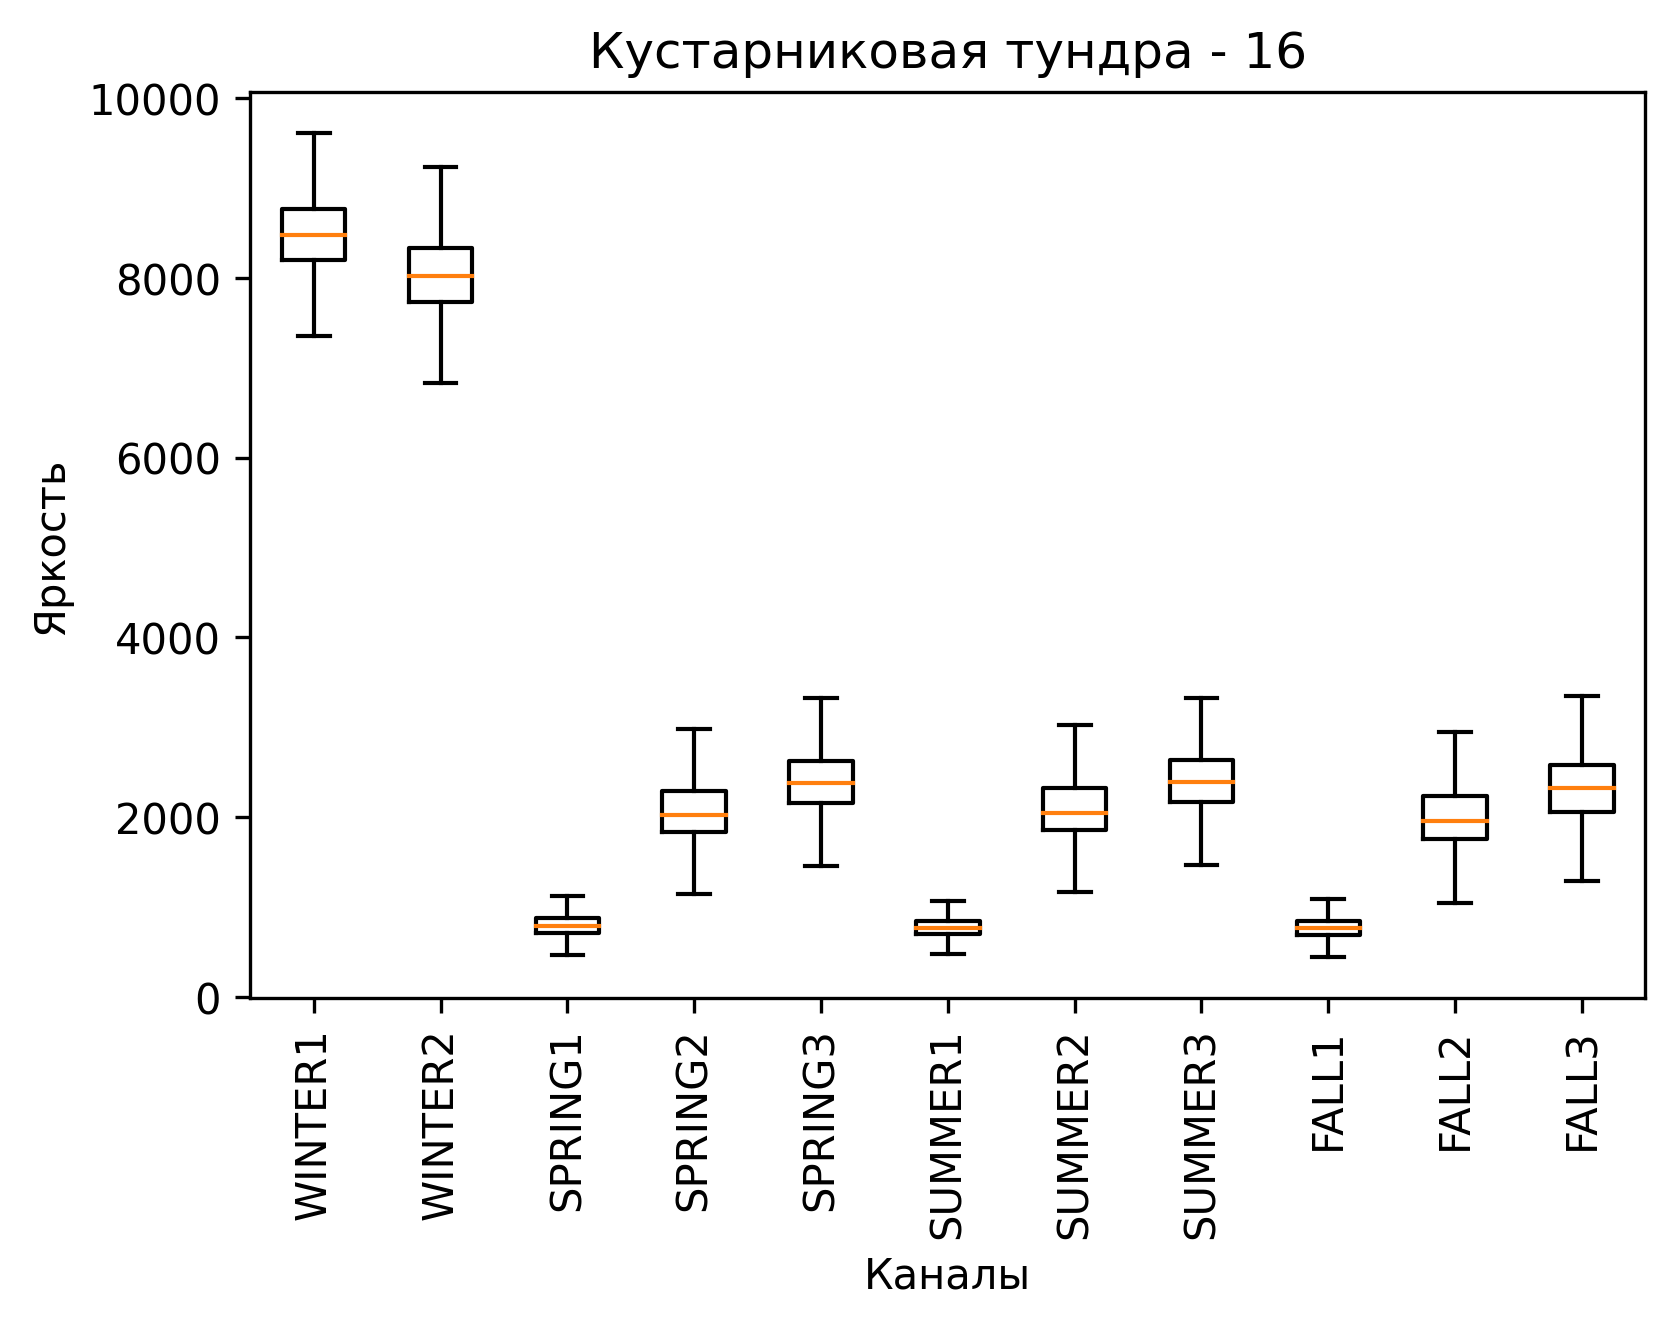

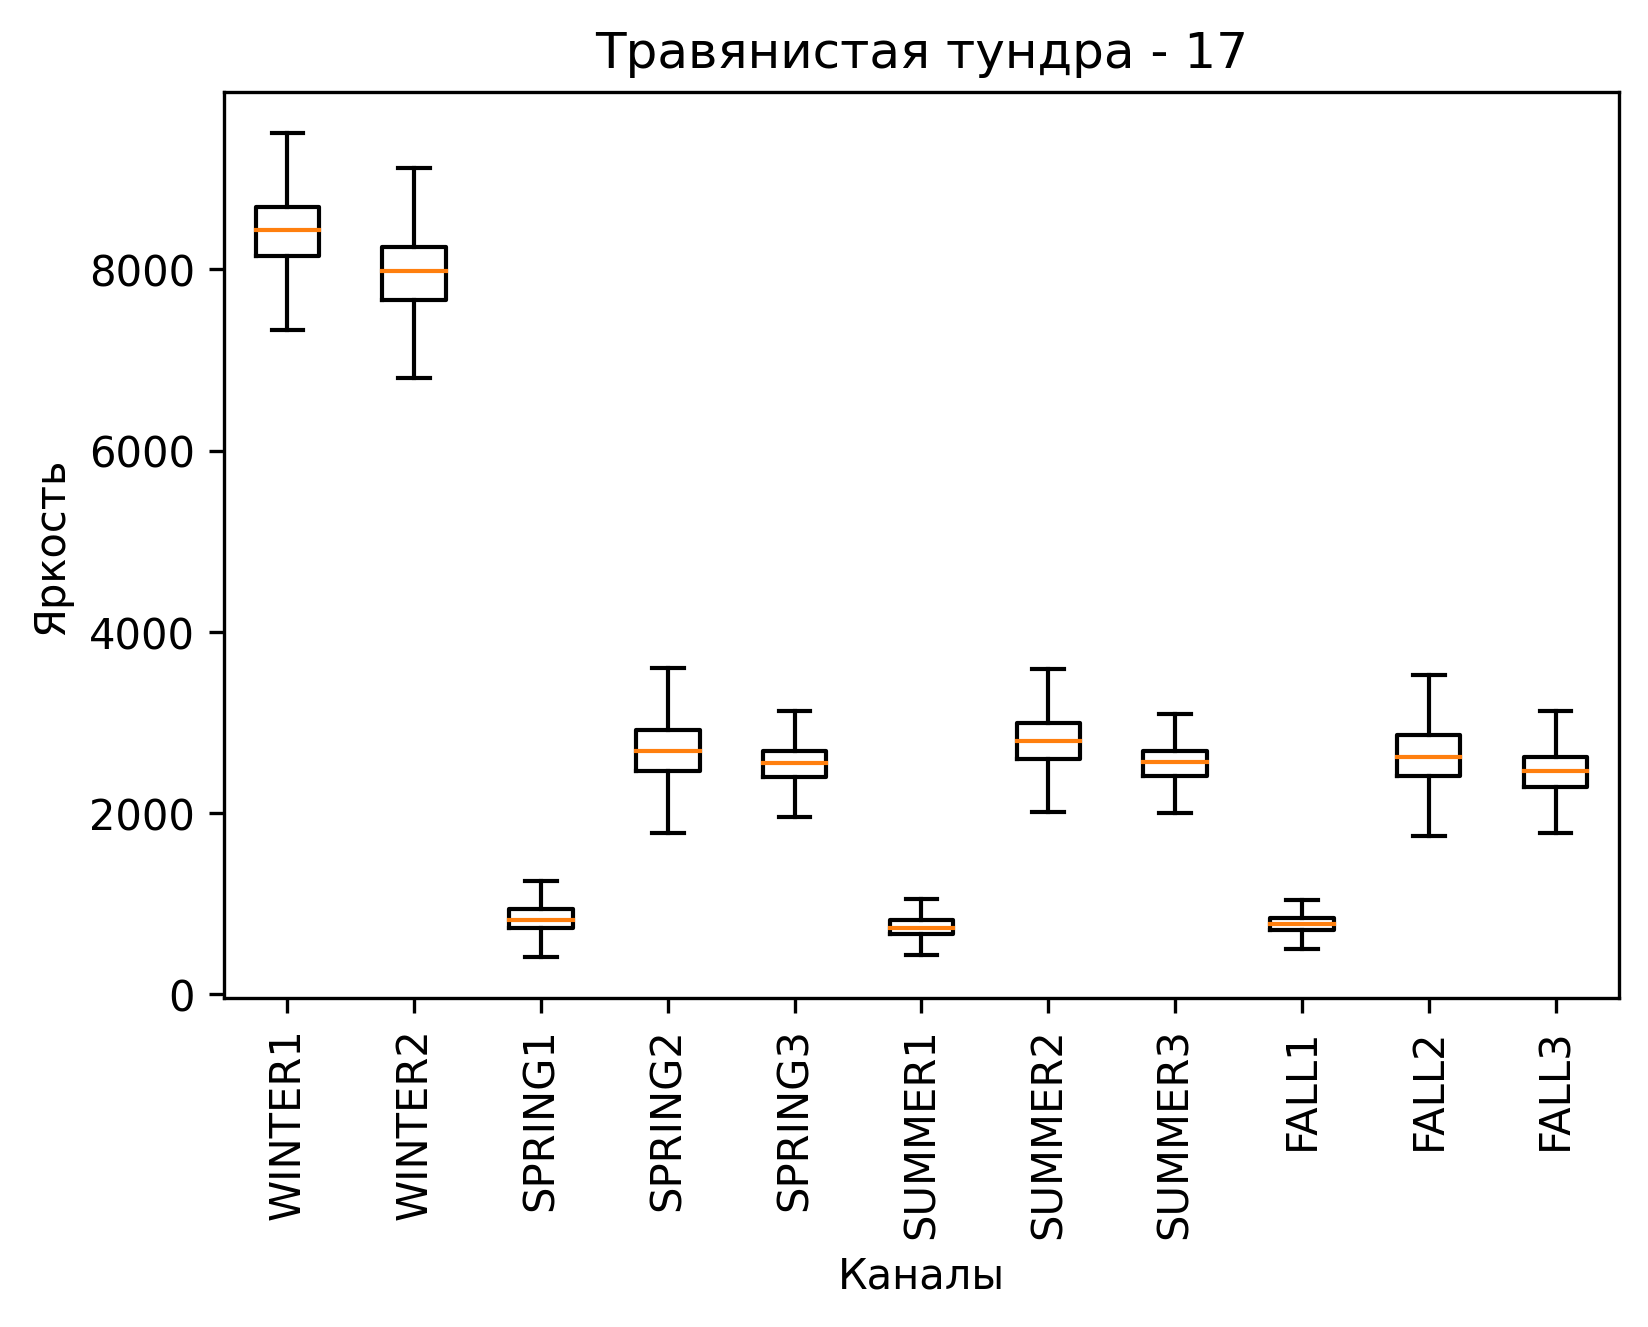

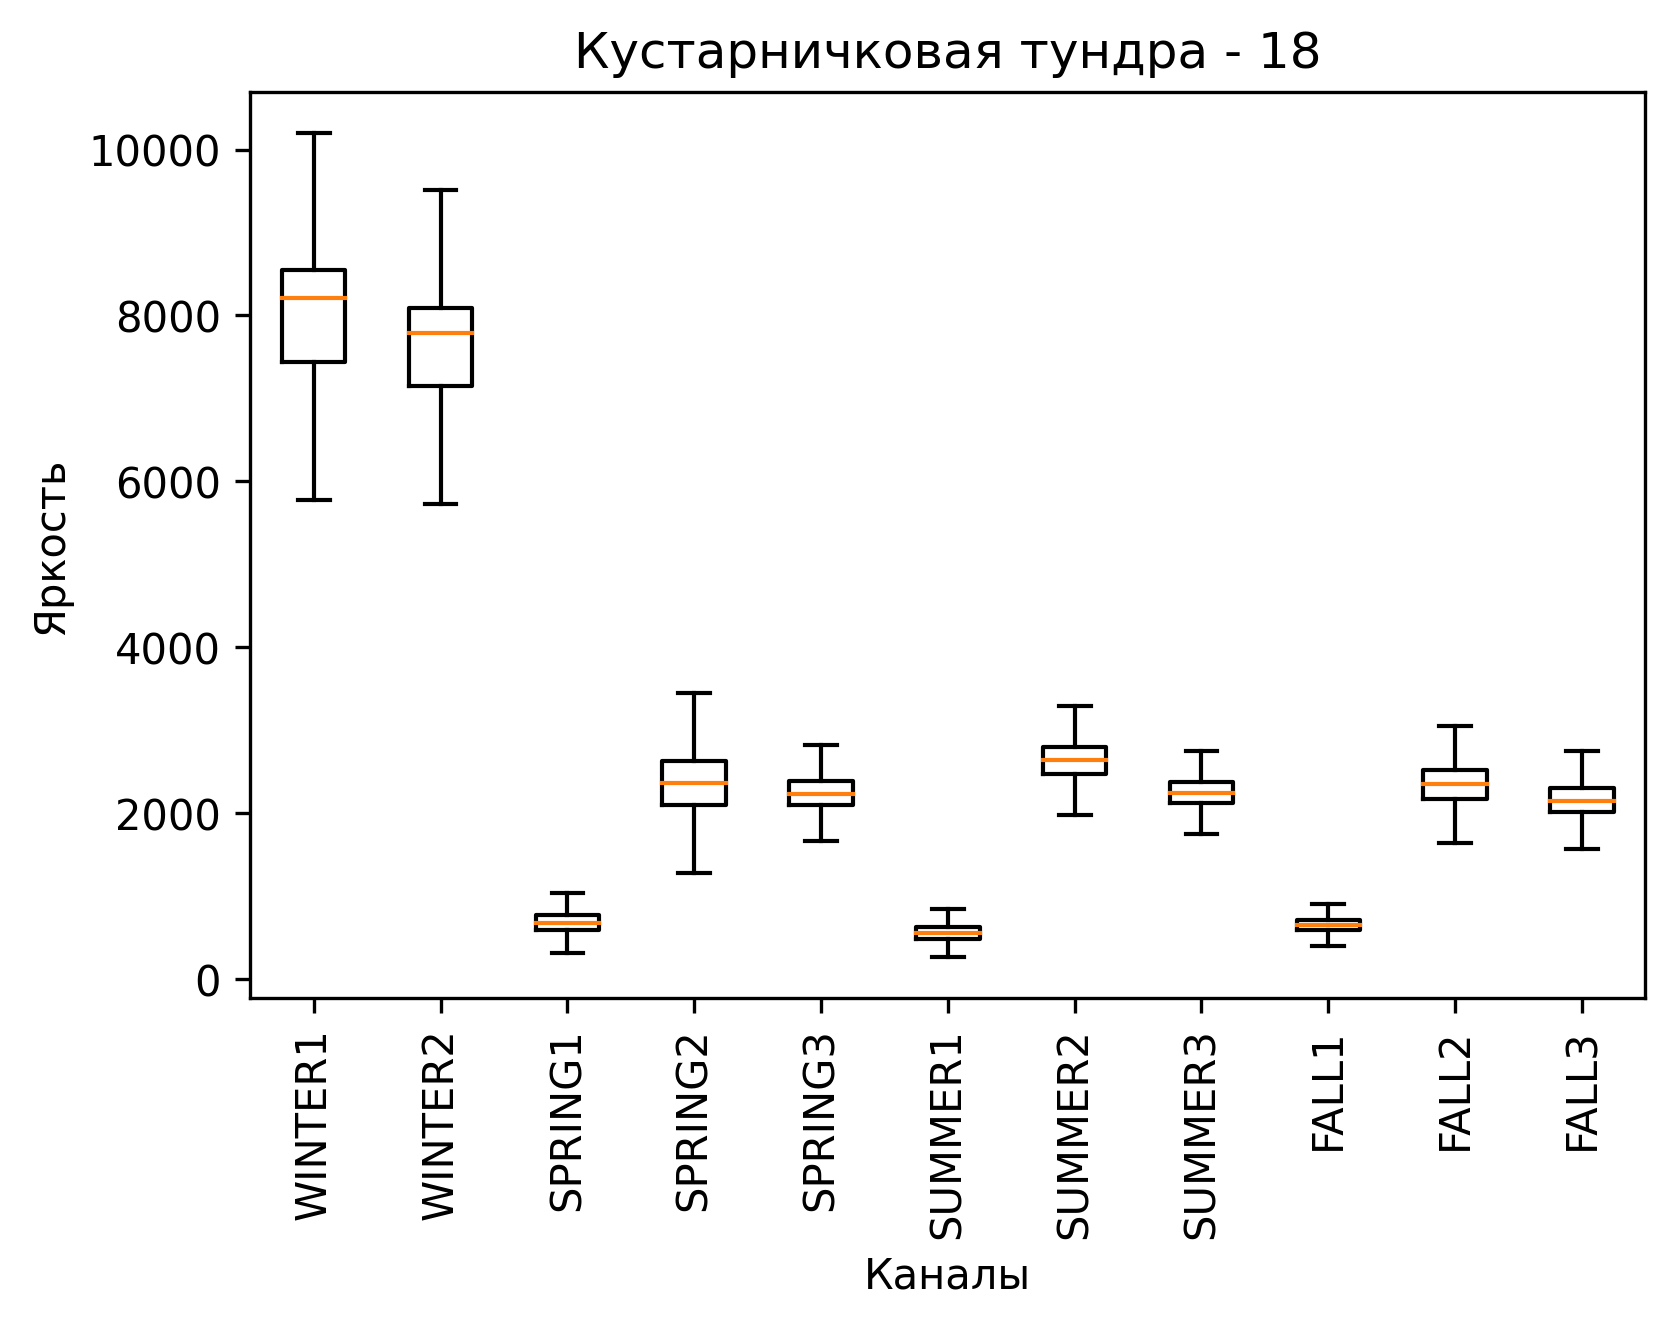

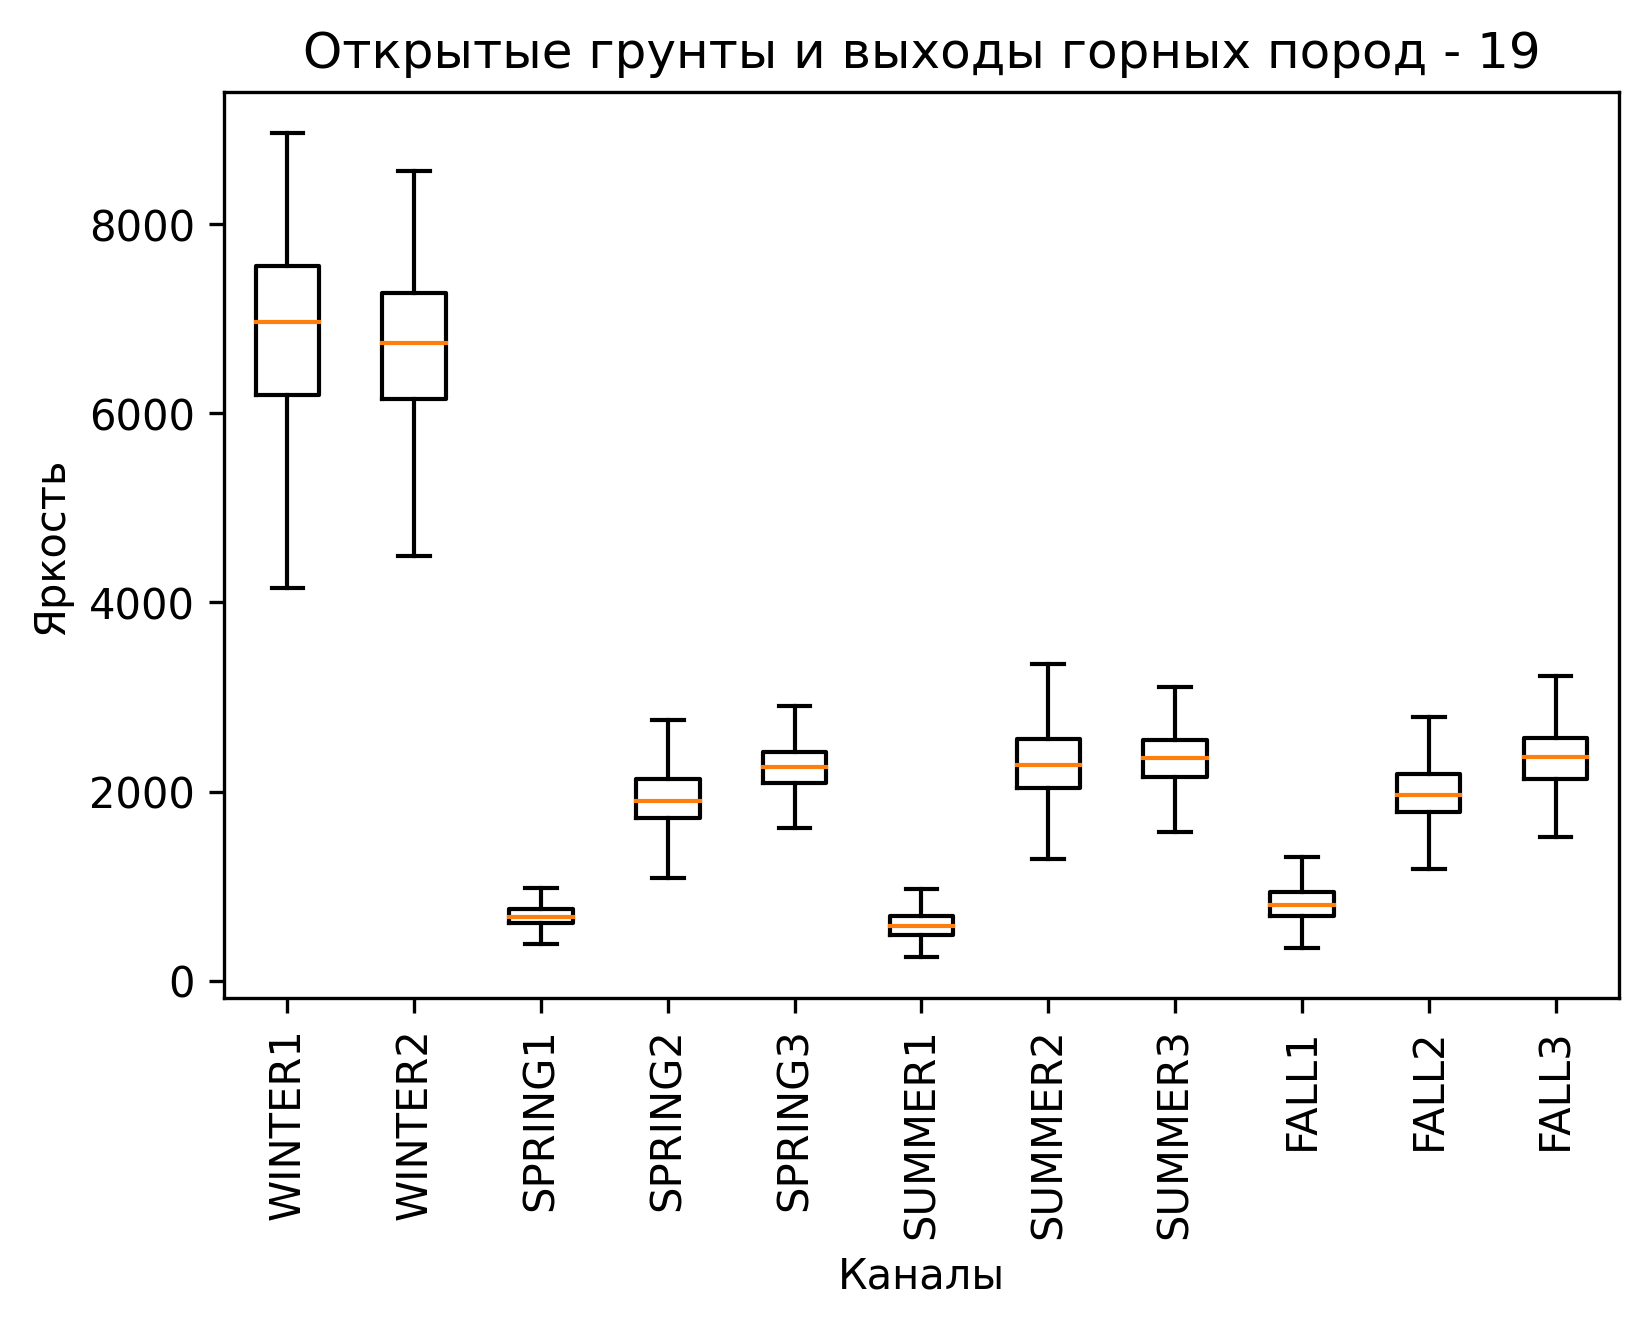

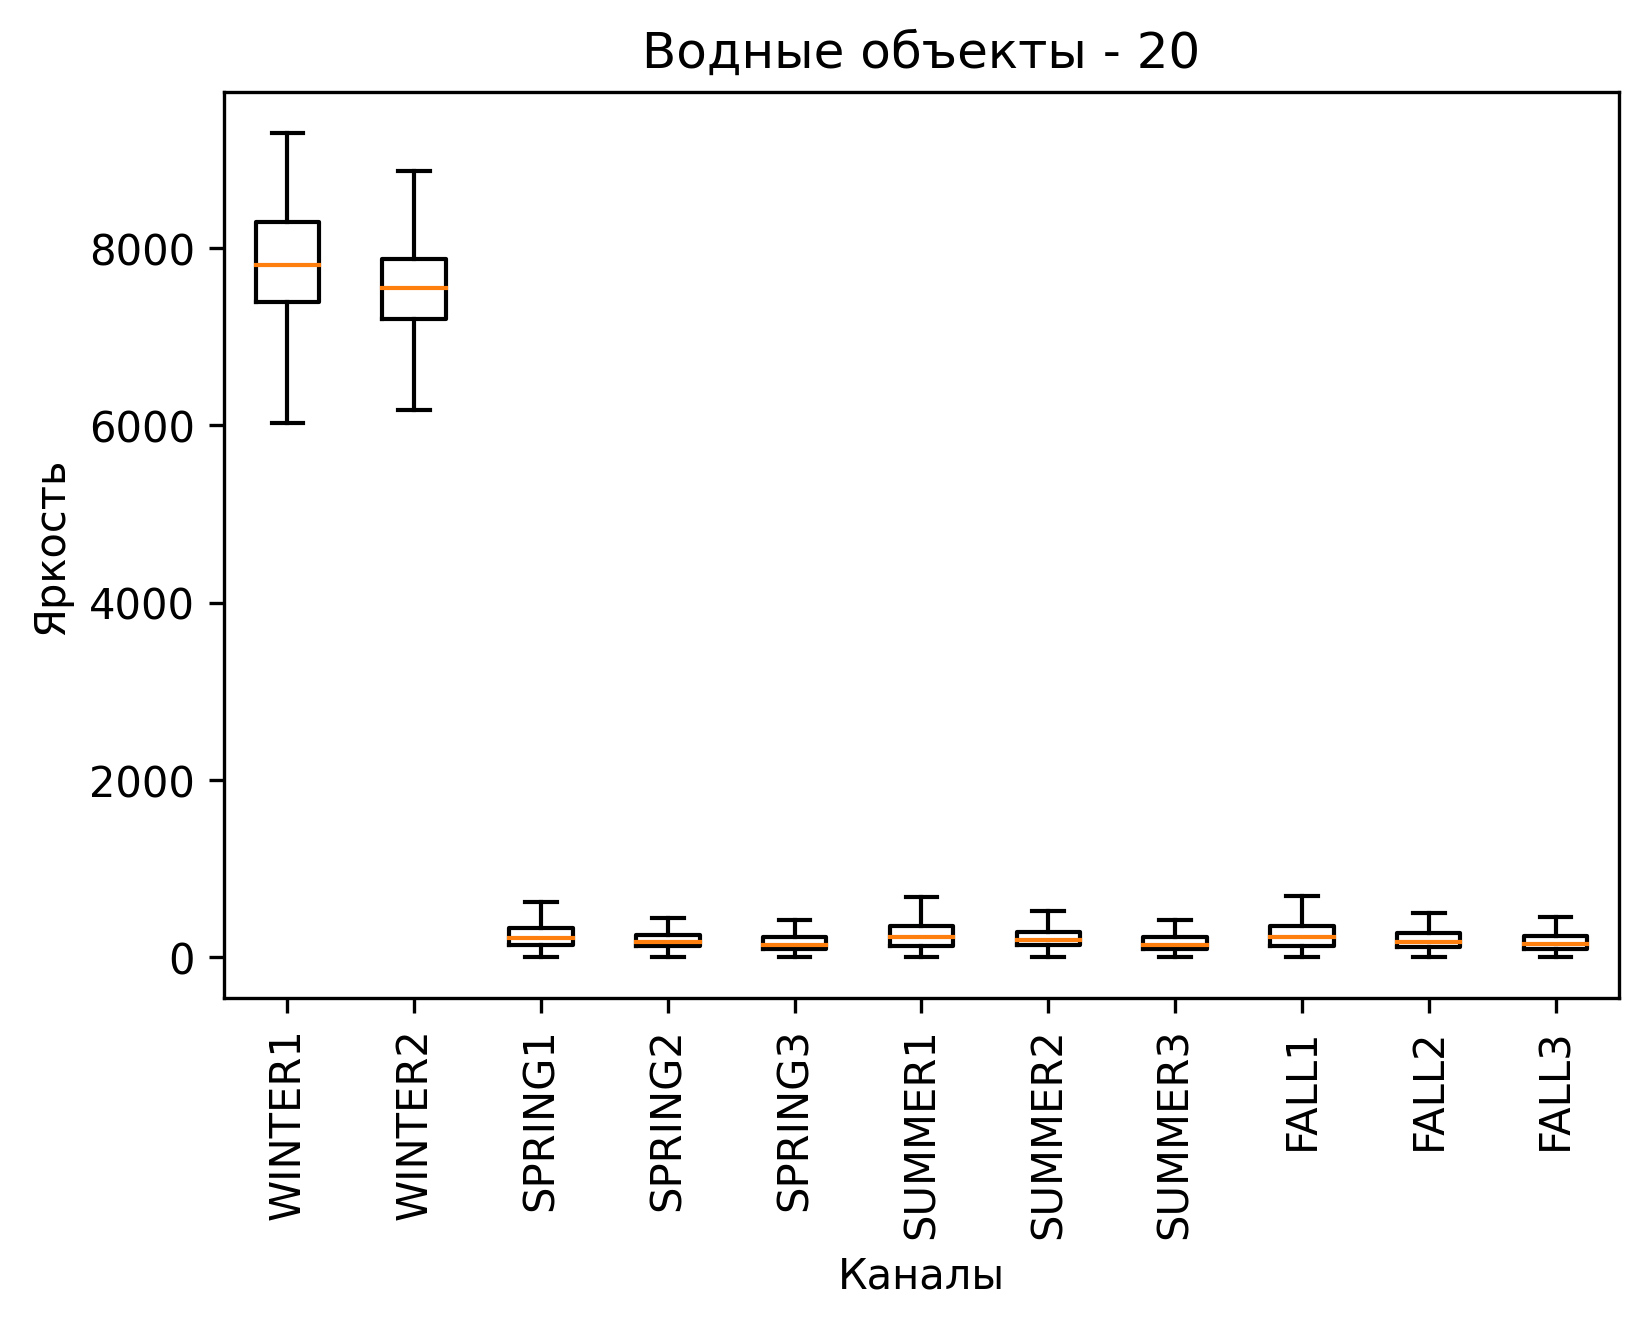

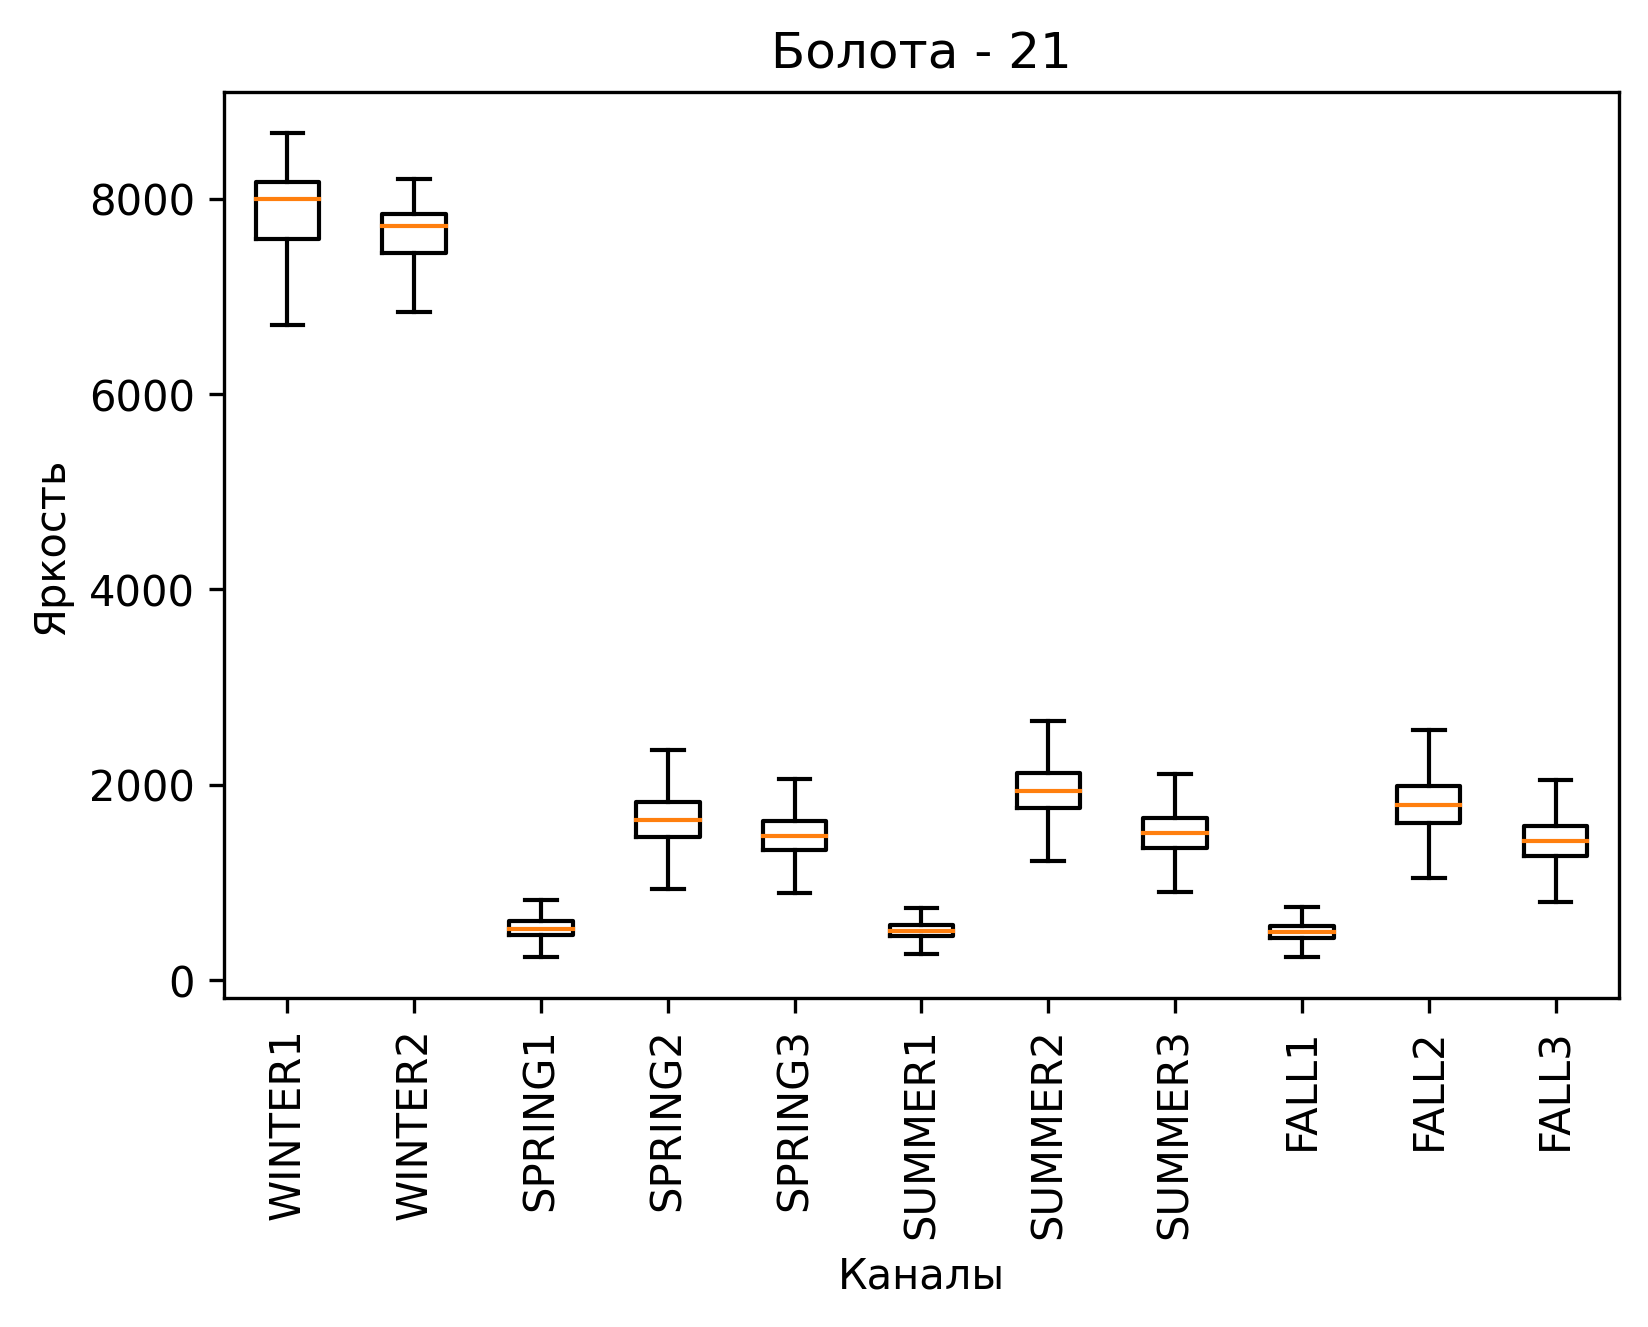

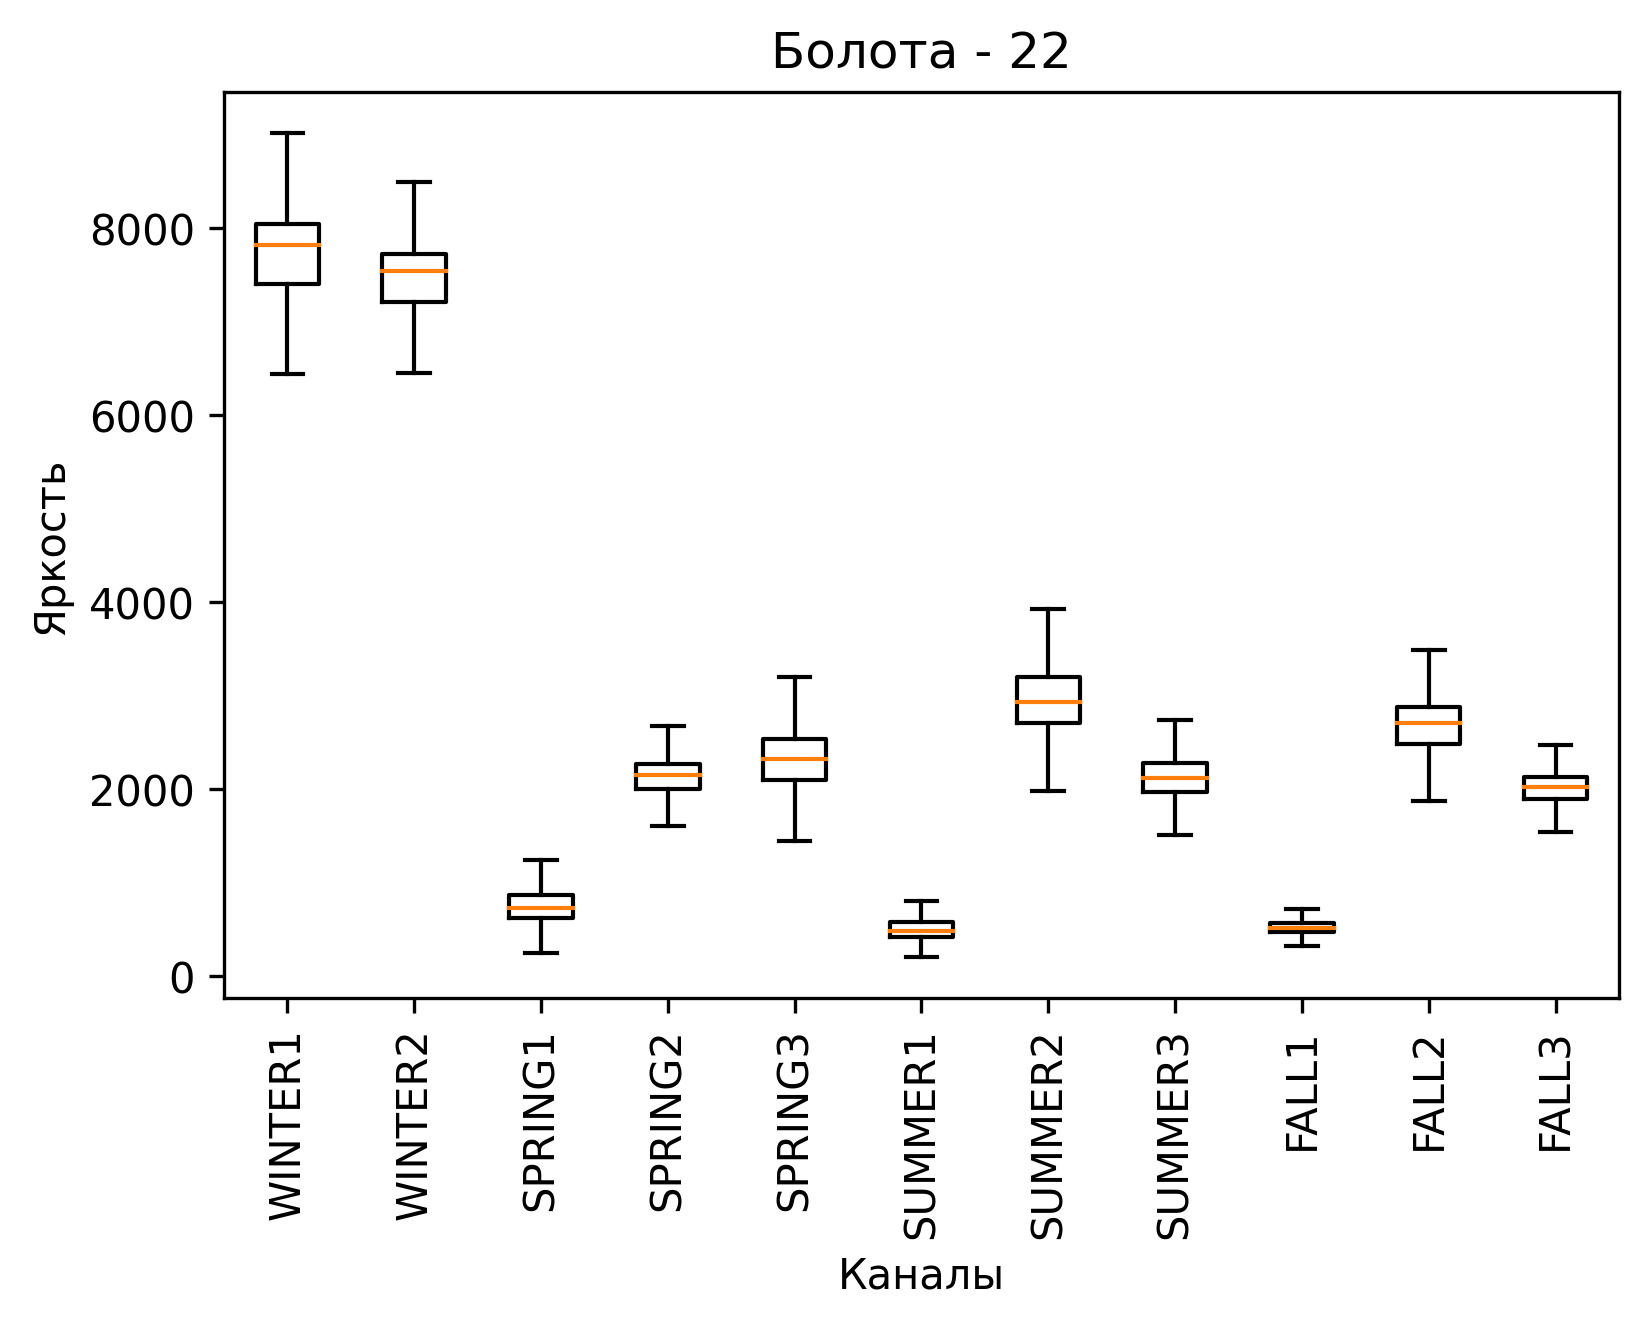

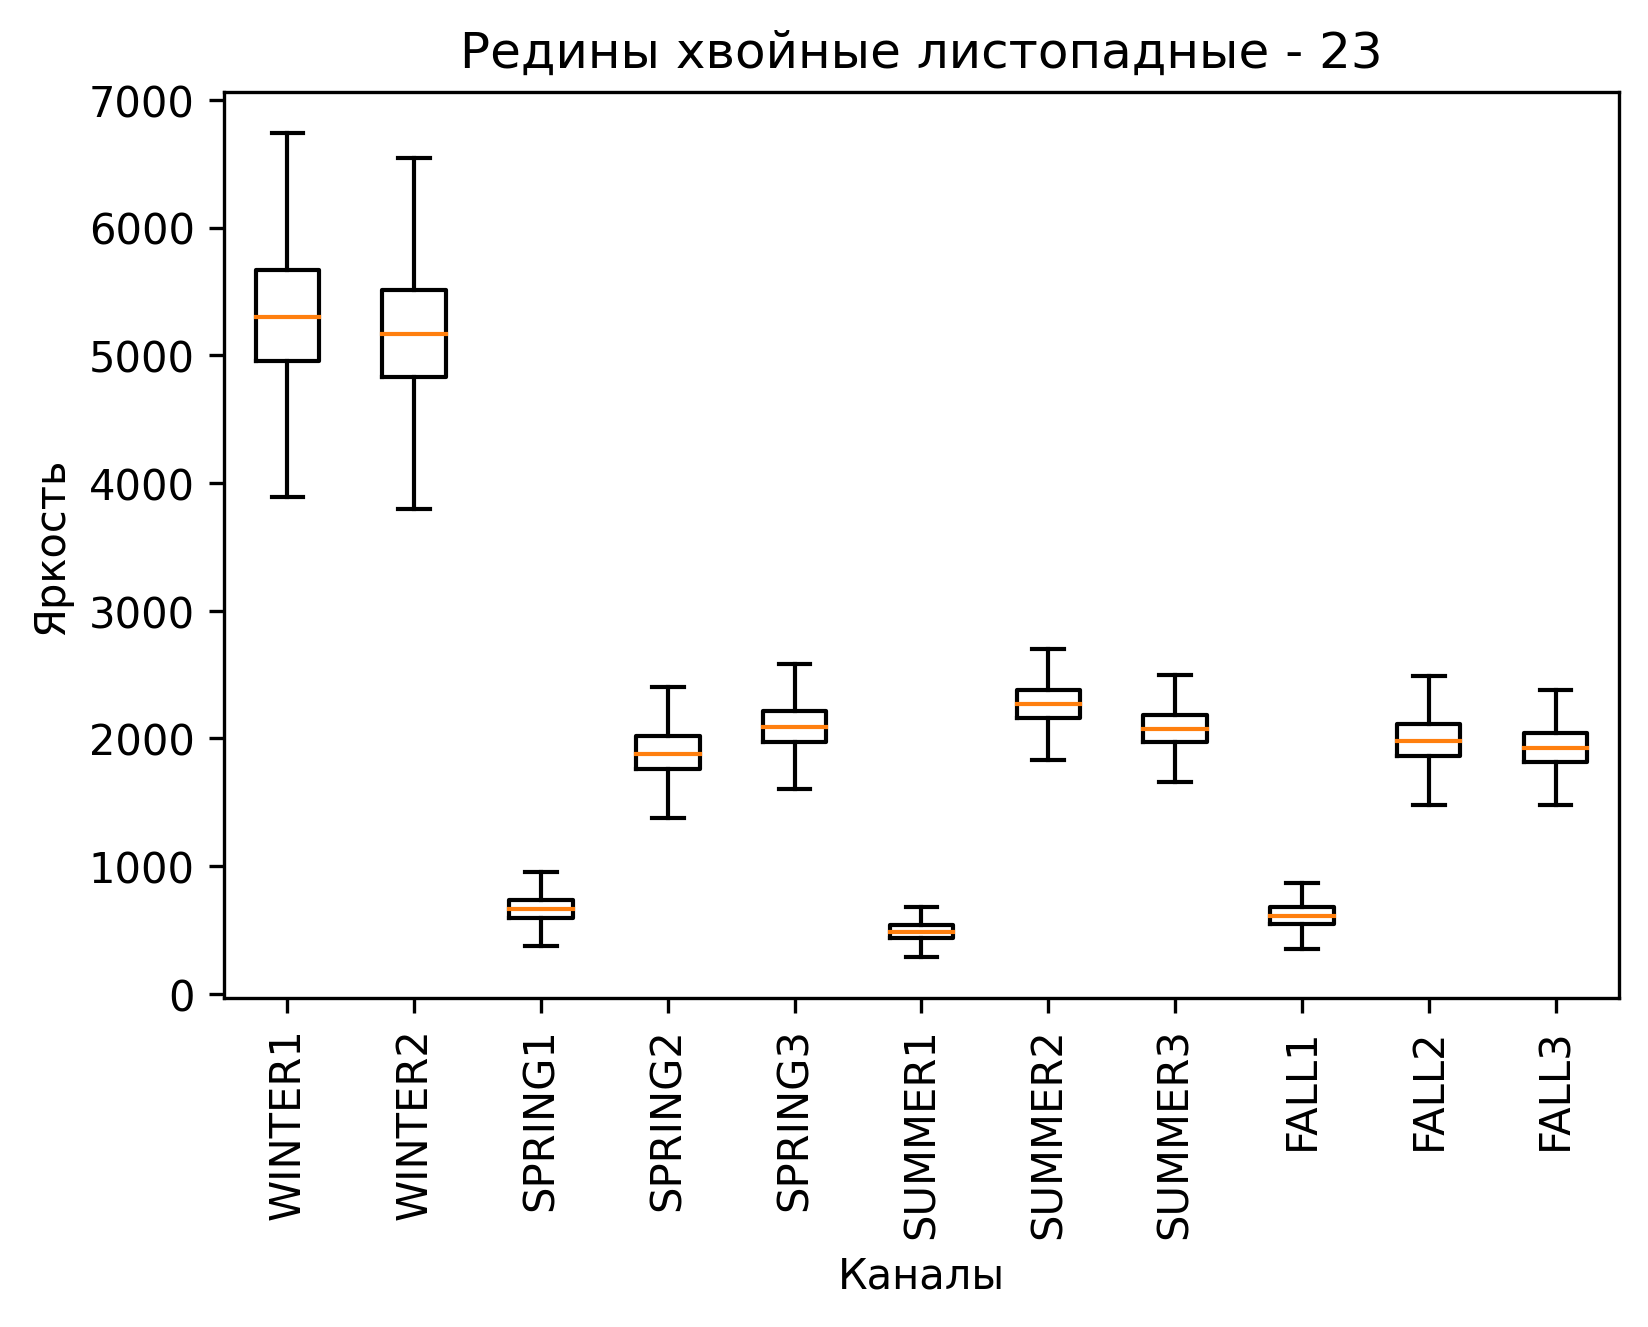

CPU times: total: 9min 25s
Wall time: 2h 6min 3s


In [63]:
%%time

# spread = np.random.rand(50) * 100
# center = np.ones(25) * 40
# flier_high = np.random.rand(10) * 100 + 100
# flier_low = np.random.rand(10) * -100
# data = np.concatenate((spread, center, flier_high, flier_low))

# data = [data, data, data[::2]]
for class_id in classes_legend:
    class_name = classes_legend[class_id]
    data = data_vaex[data_vaex["CLASS"] == class_id][brightness_column_names]
    fig, ax = plt.subplots(dpi=300)
    ax.boxplot(data, showfliers=False)
    ax.set_title(f'{class_name} - {class_id}')
    ax.set(xlabel='Каналы', ylabel='Яркость')
    plt.xticks(list(range(1, len(brightness_column_names) + 1)), brightness_column_names, rotation = 90)

    plt.show()

In [61]:
%%time

# a = data_vaex[data_vaex["CLASS"] == classes_summary[class_name]['id']]
# a.CLASS.unique()
classes_summary[class_name]['id']
class_name

CPU times: total: 0 ns
Wall time: 0 ns


'Водные объекты'